## <center>Analysis of Li-ion battery electrochemical impedance spectroscopy data: An easy-to-implement approach for physics-based parameter estimation using an open-source tool</center>

### <center>Matthew D. Murbach and Daniel T. Schwartz <br>*Clean Energy Institute & Department of Chemical Engineering,<br>University of Washington*</center>

# <center> Supplementary Notebook </center>

## Figures

### 1. [Figure 1. Flexibility of Physics-based Model](#Figure-1.-Flexibility-of-Physics-based-Model)
### 2. [Figure 2. Analytical Limit vs. Simulated High Frequency](#Figure-2.-Analytical-Limit-vs.-Simulated-High-Frequency)
### 3. [Figure 3. ImpedanceAnalyzer input panel](#Figure-3.-ImpedanceAnalyzer-Input-Panel)
### 4. [Figure 4. Physics-based Fit Example](#Figure-4.-Physics-based-Fit-Example)
### 5 and 6. [Figures 5 and 6. Explore nearly matching spectra](#Figures-5-and-6.-Explore-nearly-matching-spectra)
### 7. [Figure 7. Local Optimization of Single Parameters](#Figure-7.-Local-Optimization-of-Single-Parameters)

## Misc

### 1. [Generate parameters for dataset](#Generate-Parameters-for-Dataset)
### 2. [Join all simulation files into final dataset](#Join-all-simulation-files-into-final-dataset)

Figure 1


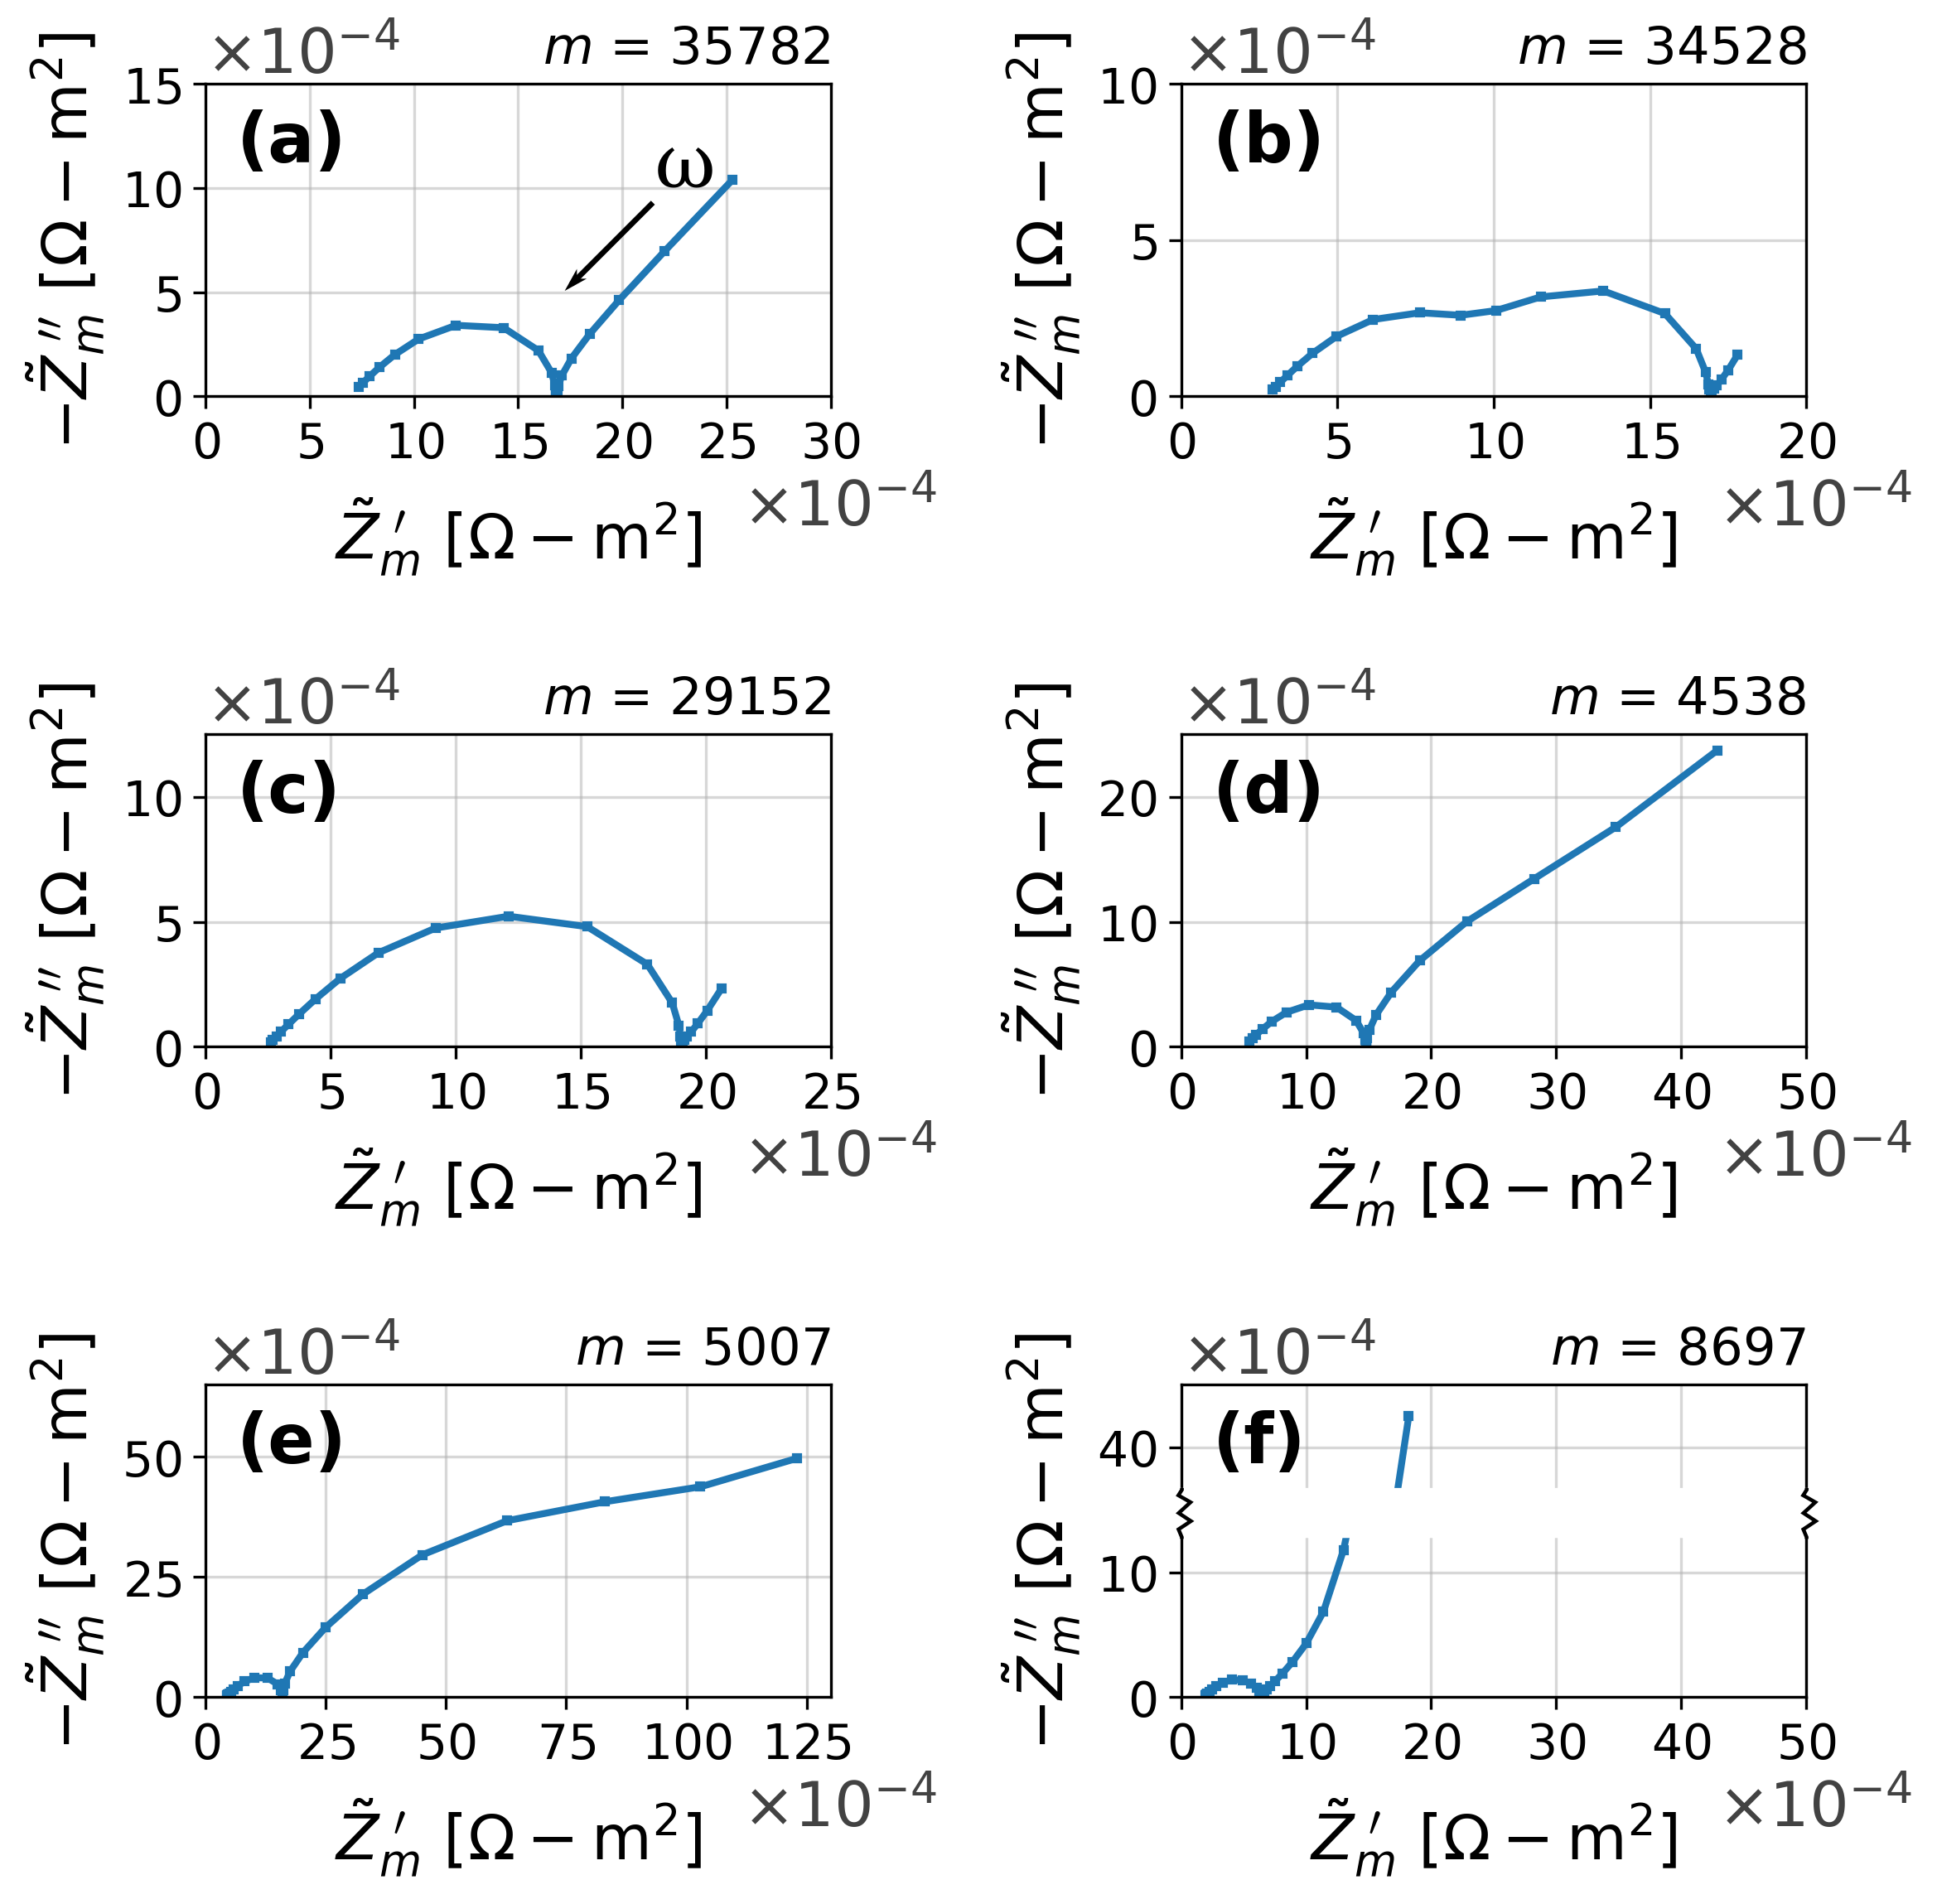

Figure 2


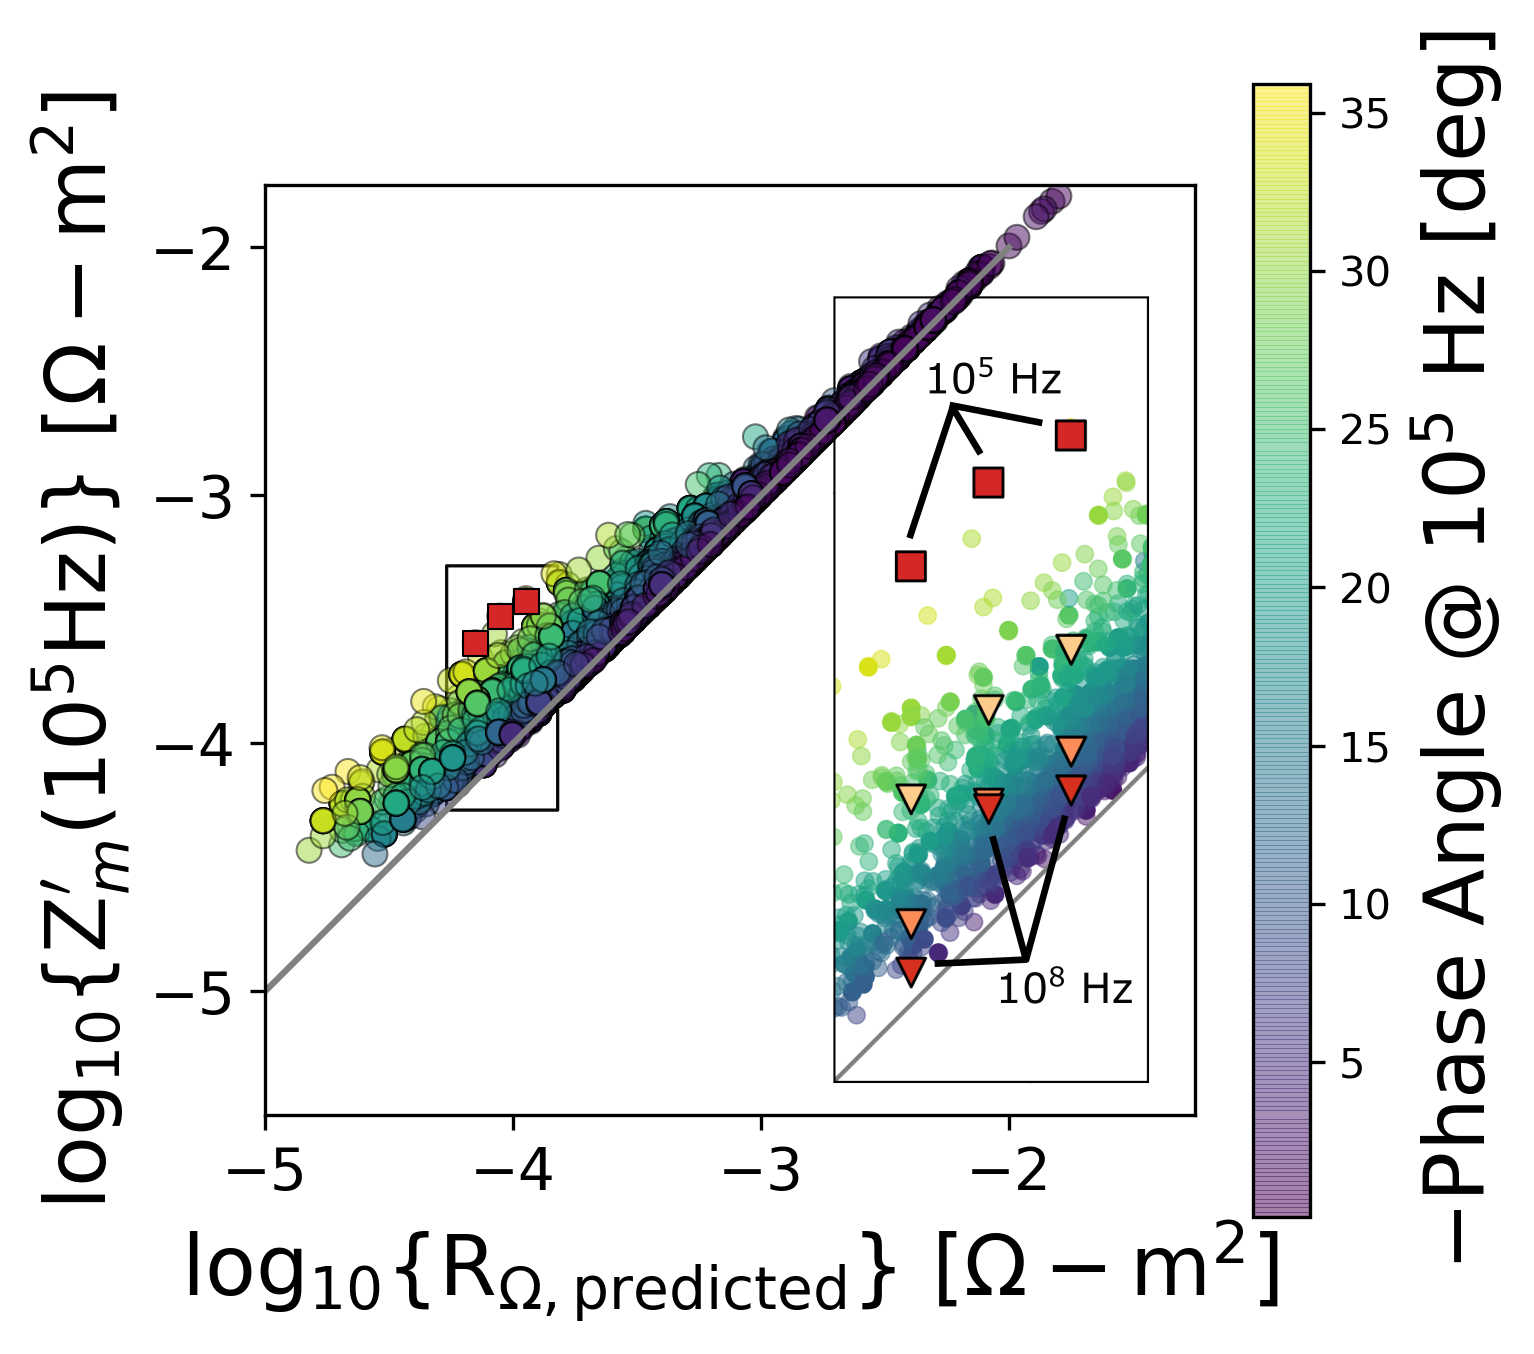

Figure 3


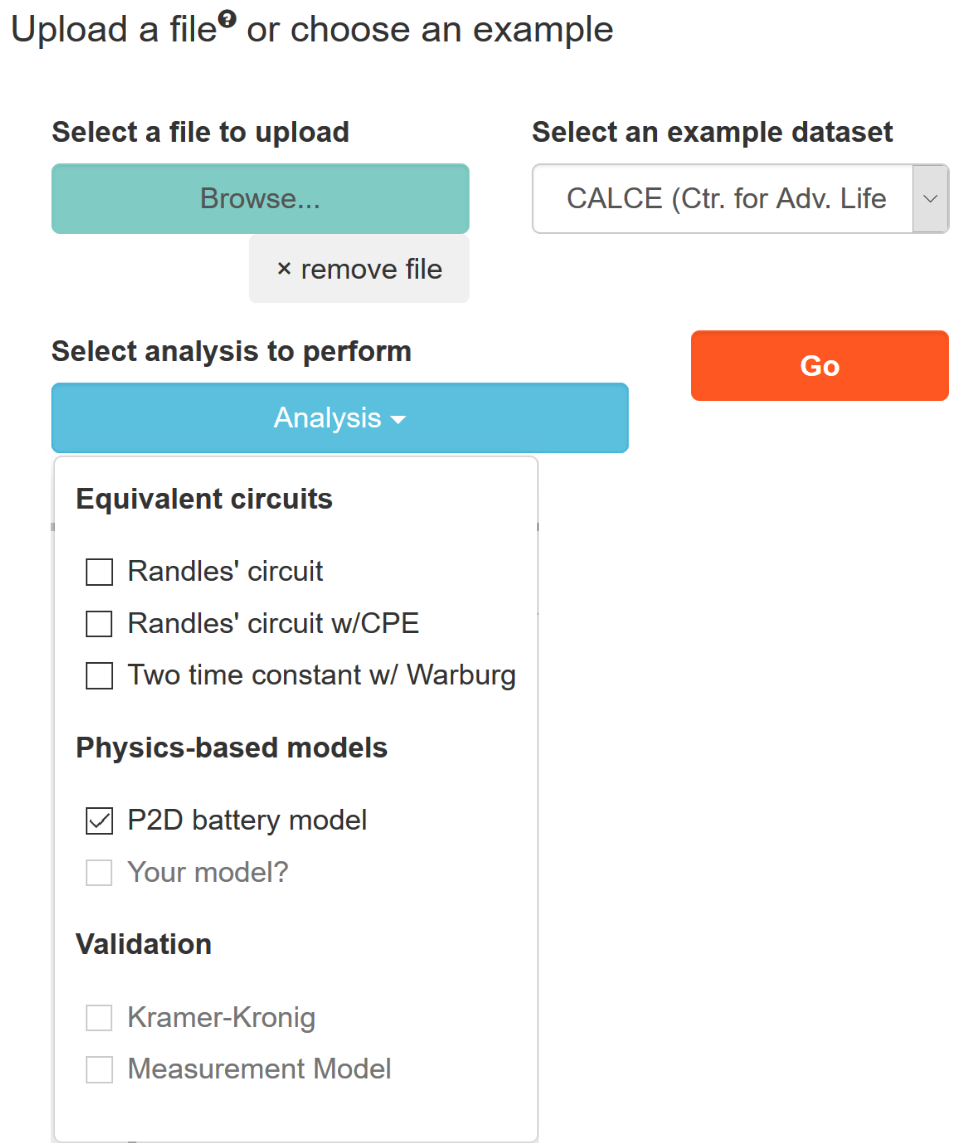

Figure 4


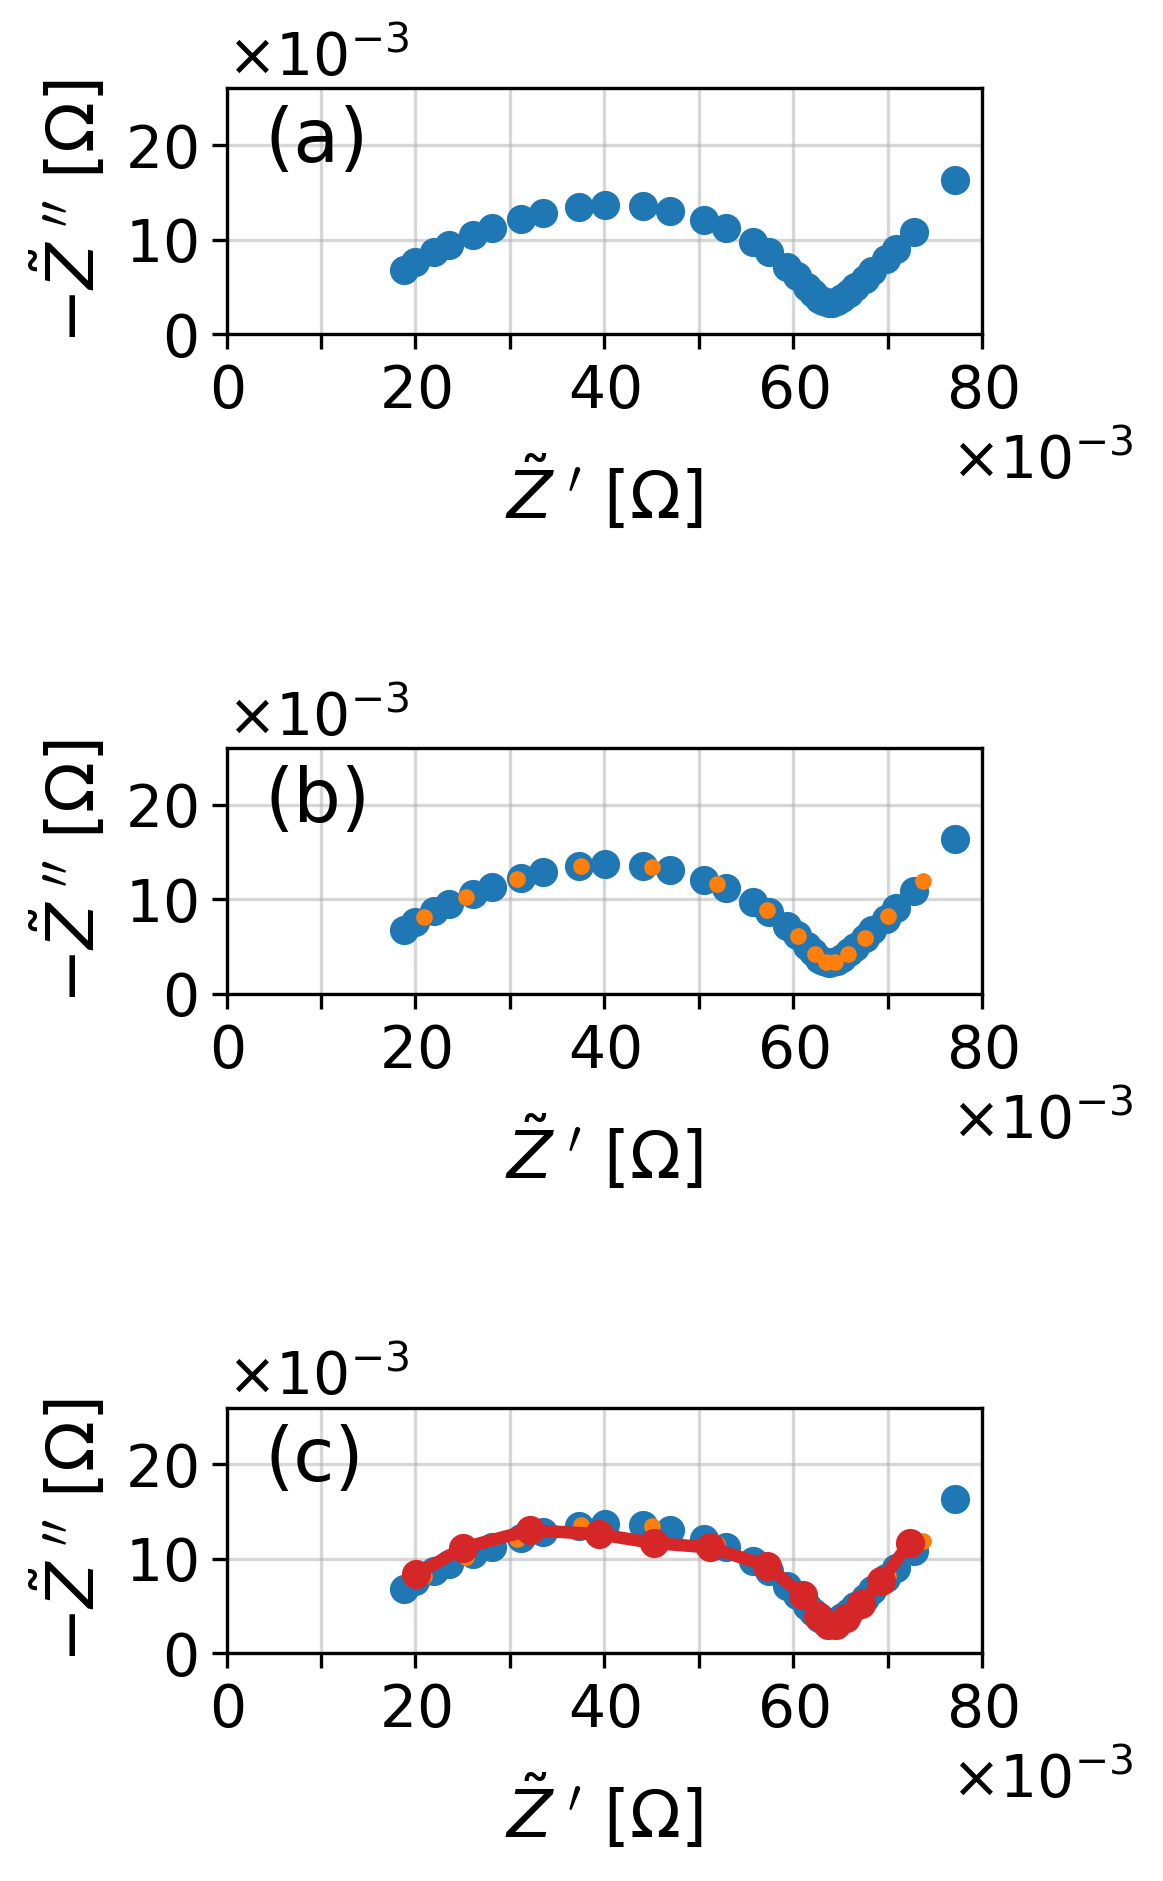

Figure 5


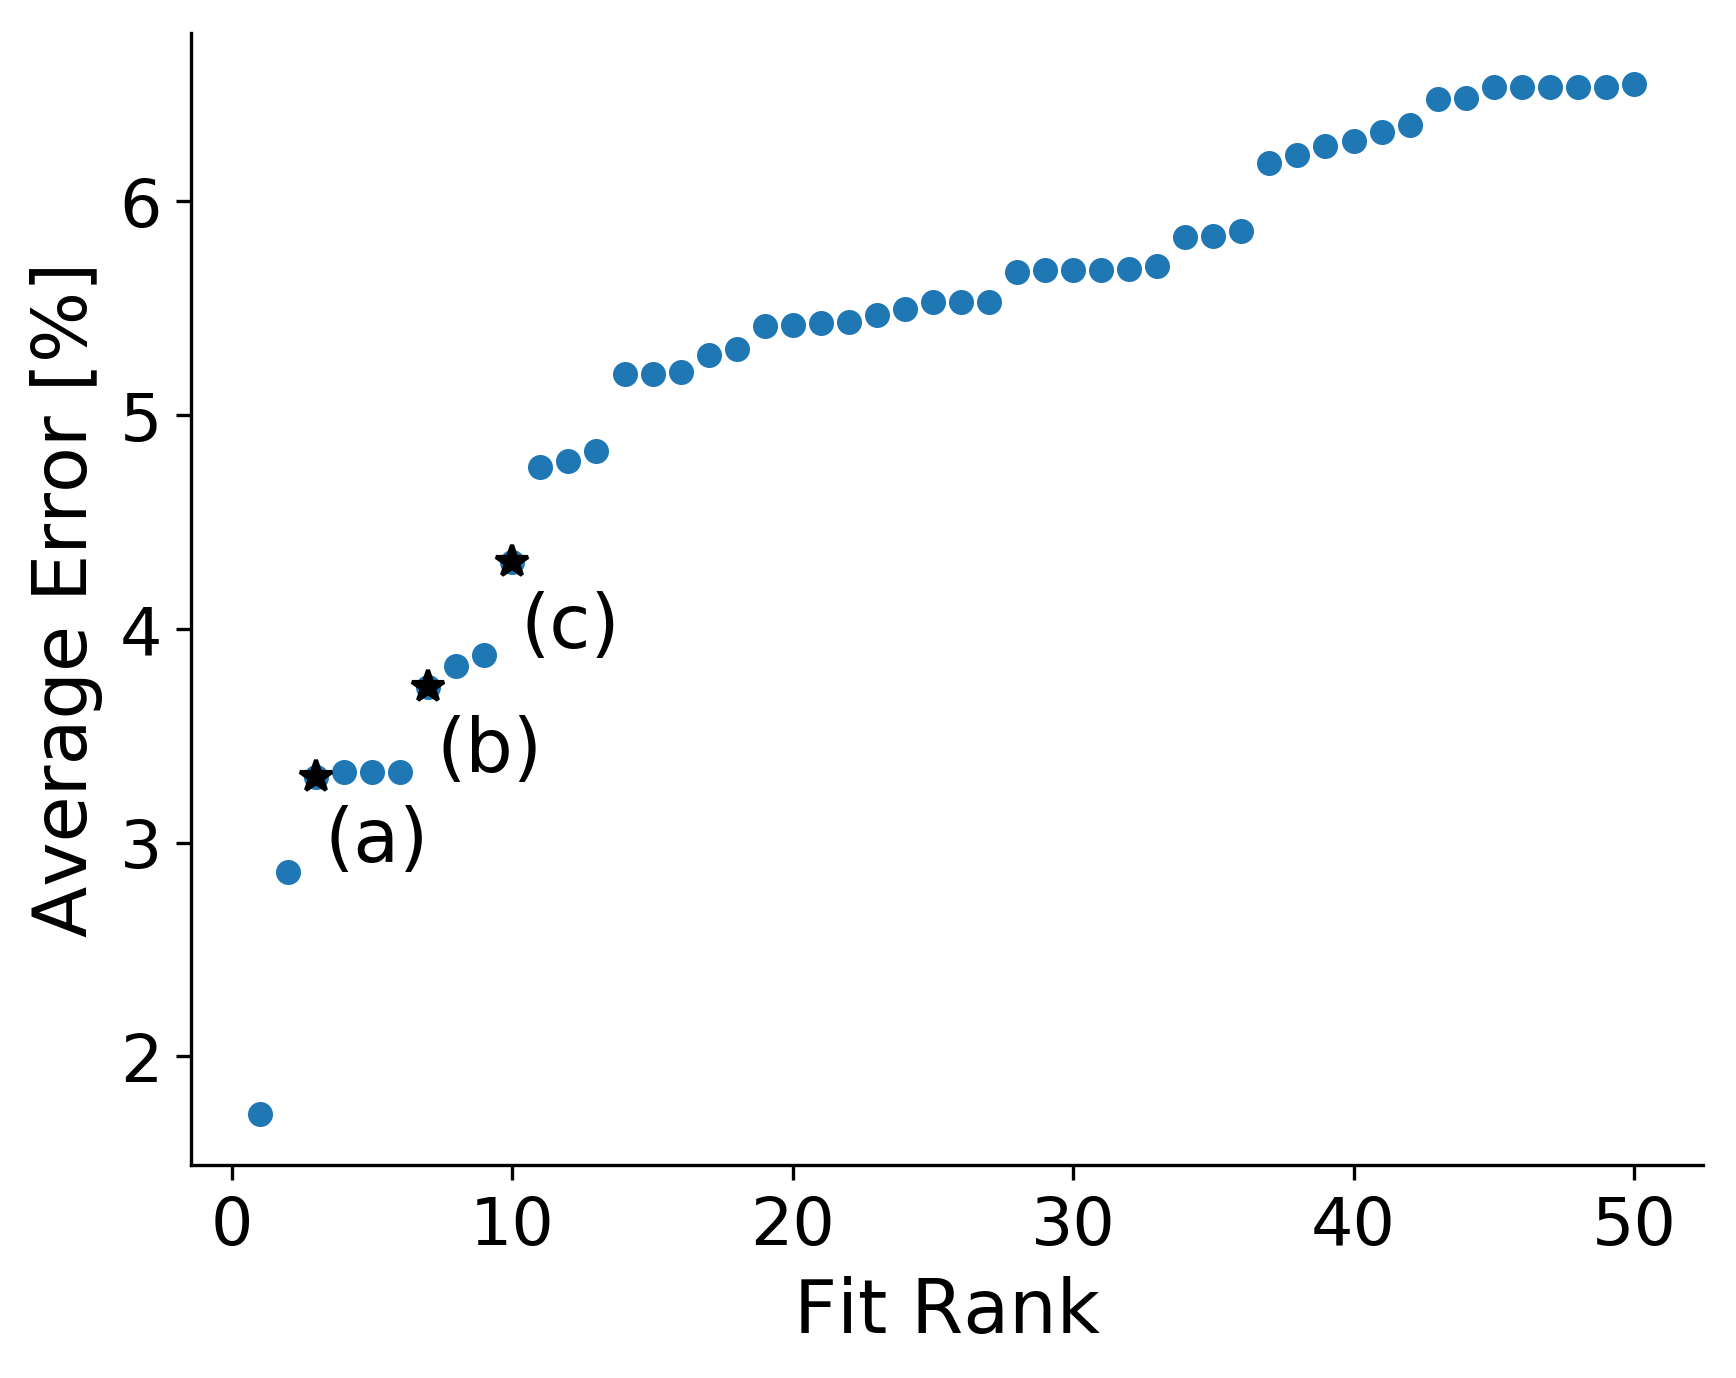

Figure 6


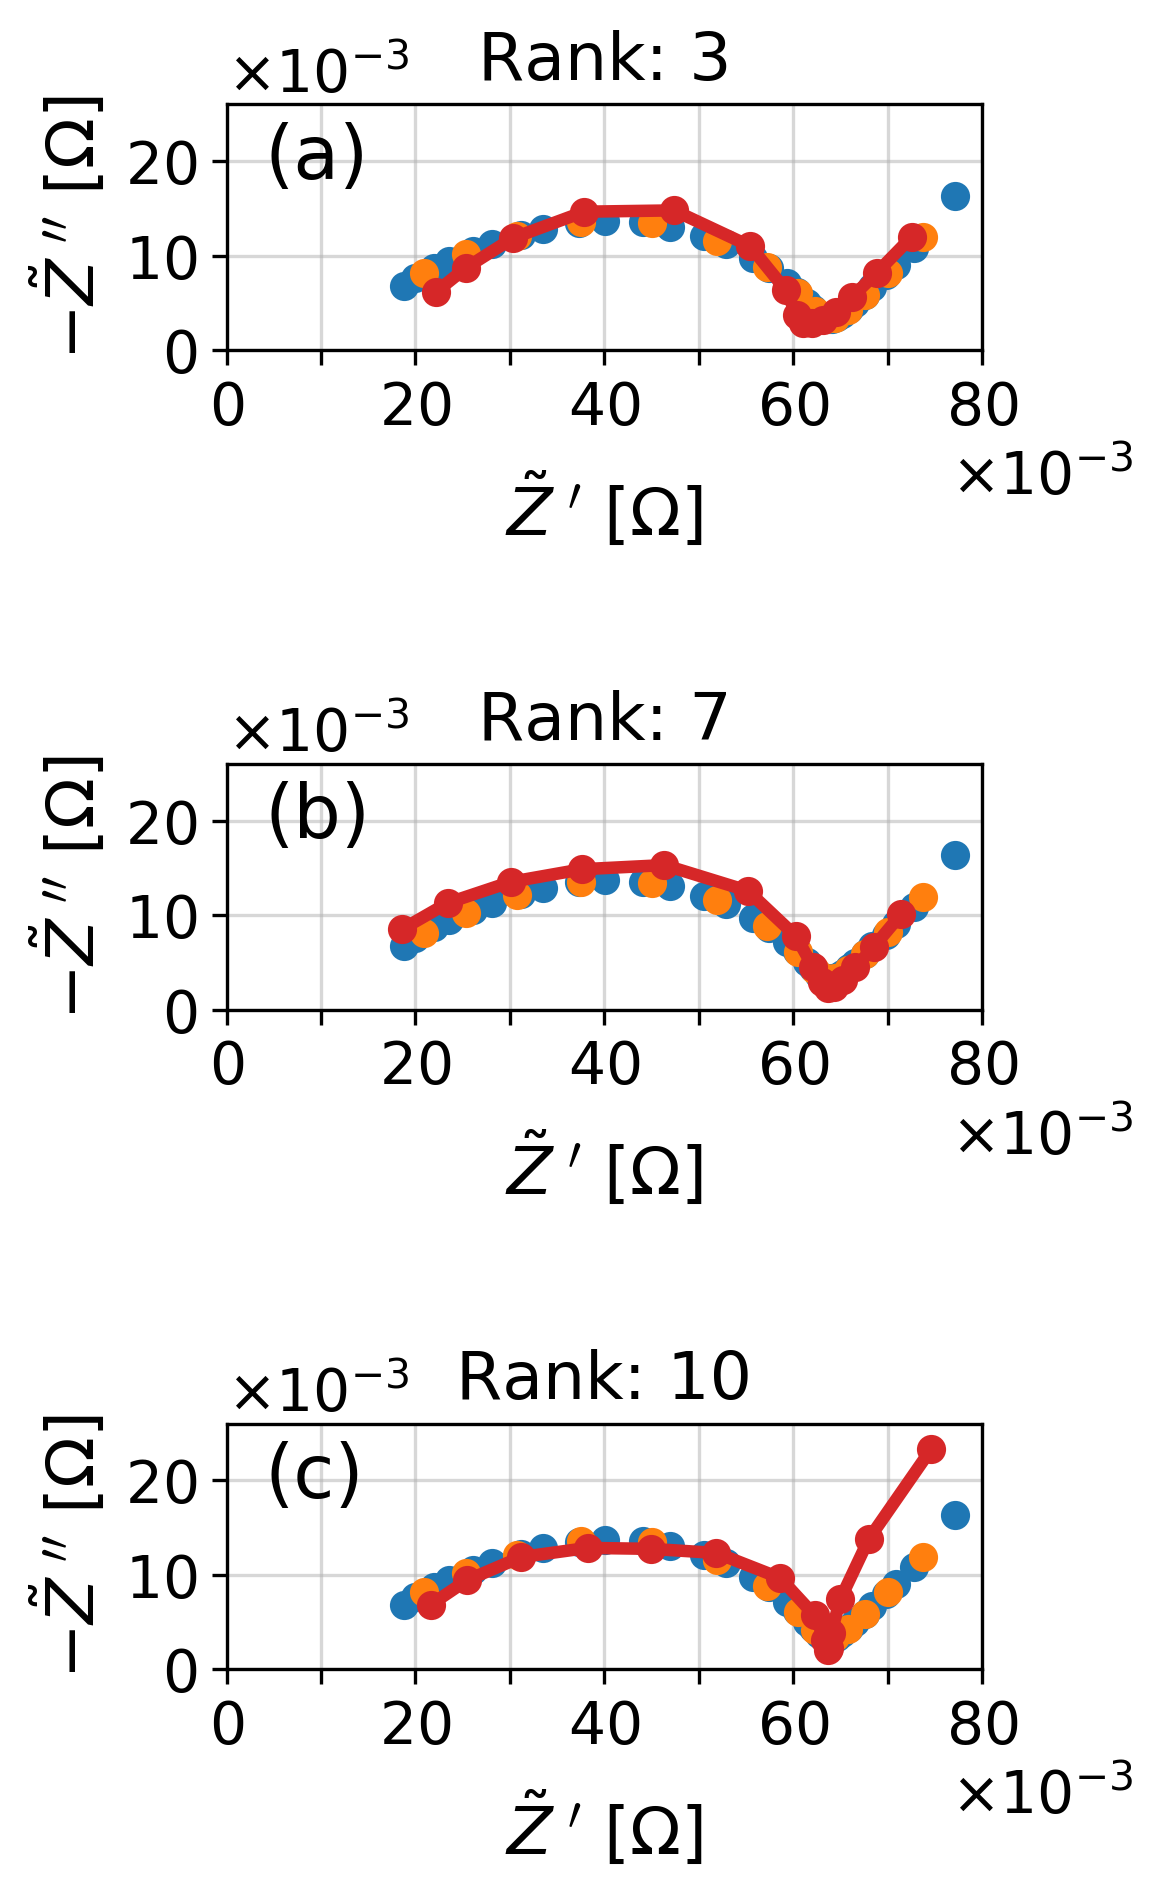

Figure 7


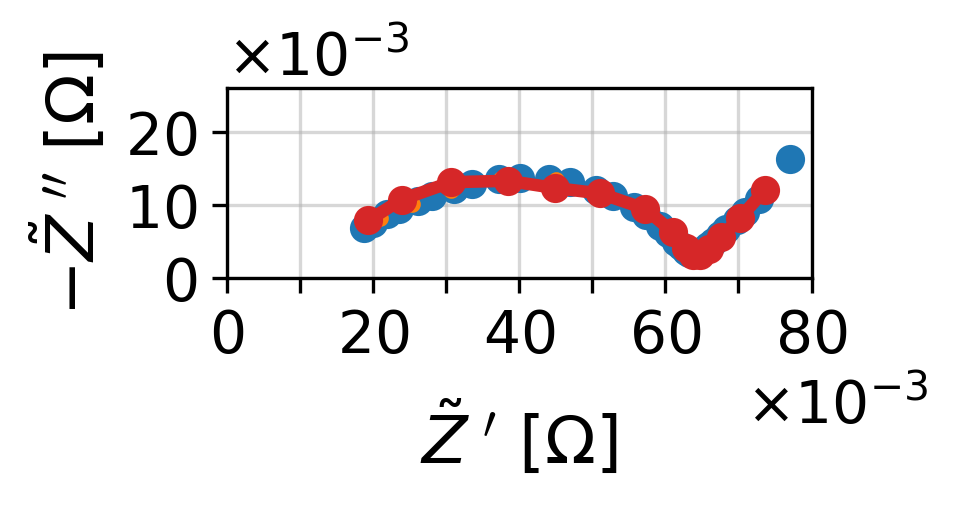

In [1]:
from IPython.display import Image
from IPython.display import display

for i in range(1,8):
    print('Figure ' + str(i))
    display(Image(filename='../figures/Figure ' + str(i) + '/Figure' + str(i) + '.png', width="30%"))

## Figure 1. Flexibility of Physics-based Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import FixedOrderFormatter

### Read in simulated spectra

In [3]:
Z_csv = pd.read_csv("../supplementary-files/dataset/38800-Z.csv", index_col=0)
    
real = [a for a in Z_csv.columns if 'real' in a]
real_df = Z_csv[real]
real_df.columns = [float(a.split('_real')[0]) for a in real_df.columns]

imag = [a for a in Z_csv.columns if 'imag' in a]
imag_df = Z_csv[imag]
imag_df.columns = [float(a.split('_imag')[0]) for a in imag_df.columns]

Z = real_df + imag_df*1j

parameters = pd.read_csv('../supplementary-files/dataset/model_runs.txt', nrows = len(Z))
parameters.index = parameters['run']

### Calculate Time Constants for Kinetics + Diffusional Processes

In [4]:
def calc_kinetics_time_constants(d, electrode):
    i0 = d['i0_' + electrode + '[A/m^2]']
    Cdl = d['Cdl_' + electrode + '[uF/cm^2]']*(100**2)*10**-6
    
    F = 96487
    R = 8.314
    T = 298.15
    
    return Cdl*R*T/(i0*F)

def calc_solid_diffusion_time_constants(d, electrode):
    R = d['Rp_' + electrode + '[m]']
    D = d['Ds_' + electrode + '[m^2/s]']
    
    return R**2/D

def calc_solution_diffusion_time_constants(d):
    l= d['l_sep[m]']
    D = d['D[m^2/s]']
    
    return l**2/D

neg_kinetics = parameters.apply(calc_kinetics_time_constants, axis=1, args=(['neg']))
pos_kinetics = parameters.apply(calc_kinetics_time_constants, axis=1, args=(['pos']))

neg_diffusion = parameters.apply(calc_solid_diffusion_time_constants, axis=1, args=(['neg']))
sep_diffusion = parameters.apply(calc_solution_diffusion_time_constants, axis=1)
pos_diffusion = parameters.apply(calc_solid_diffusion_time_constants, axis=1, args=(['pos']))

### Remove Extremes of High and Low Time Constants

In [5]:
pos_kinetics = pos_kinetics[pos_kinetics > .0001]
neg_kinetics = neg_kinetics[neg_kinetics > .0001]

pos_diffusion = pos_diffusion[pos_diffusion < 1000]
neg_diffusion = neg_diffusion[neg_diffusion < 1000]

### Calculate tail angle and ratio

In [6]:
def get_tail_ratio(d):
    hf = np.real(d.loc[1e5])
    base = np.real(d.loc[1])
    tip = np.real(d.loc[0.001])
    
    return (tip - base)/(base - hf)

def get_tail_angle(d):
    base = d.loc[1]
    tip = d.loc[0.001]
    
    return np.arctan(-tip.imag/(tip.real - base.real))

tail_angle = Z.apply(get_tail_angle, axis=1)*180/np.pi
tail_ratio = Z.apply(get_tail_ratio, axis=1)

### Plot selected examples

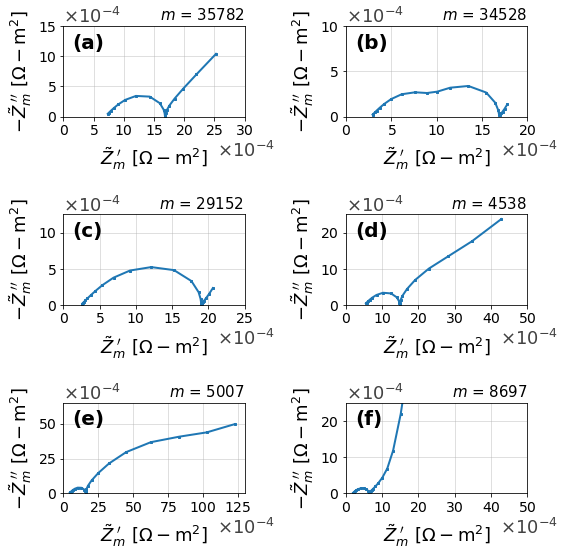

In [7]:
indexes = []

# (a) one kinetic arc
indexes.append(np.argmin(abs(pos_kinetics - neg_kinetics)))

# (b) two kinetic time-constants
indexes.append(np.argmax(abs(pos_kinetics - neg_kinetics)))

# (c) large low frequency tail
indexes.append(np.argmin(abs(tail_ratio - .1)))

# (d) small low frequency tail
indexes.append(np.argmin(abs(tail_ratio - 3)))

# (e) low slope low frequency tail
indexes.append(np.argmin(abs(tail_angle - 25)))

# (f) high slope low frequency tail
indexes.append(np.argmin(abs(tail_angle - 75)))

limits = [
            [[0,.003], [0,.0015]],
            [[0,.002], [0,.001]], 
            [[0,.0025], [0,.00125]],
            [[0,.005], [0,.0025]],
            [[0,.013], [0,.0065]],
            [[0,.0050], [0,.0025]]
        ]

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig = plt.figure(3, figsize=(8,8))
# ax = fig.add_subplot(111)

for i, index in enumerate(indexes):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(Z.loc[index,:].apply(np.real), -Z.loc[index,:].apply(np.imag), 's-', 
            alpha=1, label=index, color = '#1f77b4', linewidth=2, markersize=2)

    ax.set_title('$m$ = ' + str(index), loc='right', fontsize=15)
    ax.set_xlabel(r'$\tilde{Z}_{m}^{\ \prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
    ax.set_ylabel(r'$-\tilde{Z}_{m}^{\ \prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)
    ax.locator_params(axis='x', nbins=6,tight=True)
    ax.locator_params(axis='y', nbins=3,tight=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#     txt = plt.text(.1, .7, labels[i], transform=ax.transAxes, fontsize=17)
    ax.text(0.05, .92,  labels[i], weight='bold', family='sans-serif', 
            fontsize=20, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
#     txt.set_family('sans-serif')
    
    plt.xlim(limits[i][0][0],limits[i][0][1])
    plt.ylim(limits[i][1][0],limits[i][1][1])
    
    ax.set_aspect('equal')
    ax.yaxis.set_major_formatter(FixedOrderFormatter(-4))
    ax.xaxis.set_major_formatter(FixedOrderFormatter(-4))
    
    y_offset = ax.yaxis.get_offset_text()
    y_offset.set_size(18)
    y_offset.set_color('#424242')
    t = ax.xaxis.get_offset_text()
    t.set_size(18)
    t.set_color('#424242')
    t.set_position((1.17,0))
    ax.grid(b=True, which='major', axis='both', alpha=.5)
    ax.tick_params(right="off", top="off")
        
plt.tight_layout()
plt.show()

fig.savefig('../figures/Figure 1/full.png', dpi=300, bbox_inches='tight')

### Change limits to show the extreme slope in (e)

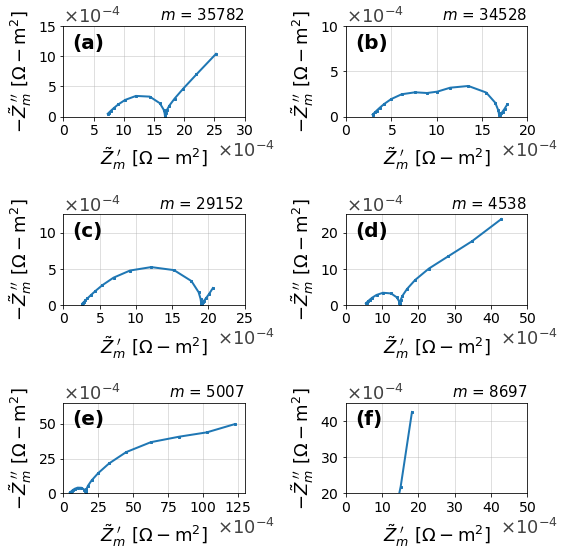

In [8]:
limits = [
            [[0,.003], [0,.0015]],
            [[0,.002], [0,.001]], 
            [[0,.0025], [0,.00125]],
            [[0,.005], [0,.0025]],
            [[0,.013], [0,.0065]],
            [[0,.0050], [0.0020,0.0045]]
        ]

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig = plt.figure(3, figsize=(8,8))
# ax = fig.add_subplot(111)

for i, index in enumerate(indexes):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(Z.loc[index,:].apply(np.real), -Z.loc[index,:].apply(np.imag), 's-', 
            alpha=1, label=index, color = '#1f77b4', linewidth=2, markersize=2)

    ax.set_title('$m$ = ' + str(index), loc='right', fontsize=15)
    ax.set_xlabel(r'$\tilde{Z}_{m}^{\ \prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
    ax.set_ylabel(r'$-\tilde{Z}_{m}^{\ \prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)
    ax.locator_params(axis='x', nbins=6,tight=True)
    ax.locator_params(axis='y', nbins=3,tight=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#     txt = plt.text(.1, .7, labels[i], transform=ax.transAxes, fontsize=17)
    ax.text(0.05, .92,  labels[i], weight='bold', family='sans-serif', 
            fontsize=20, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
#     txt.set_family('sans-serif')
    
    plt.xlim(limits[i][0][0],limits[i][0][1])
    plt.ylim(limits[i][1][0],limits[i][1][1])
    
    ax.set_aspect('equal')
    ax.yaxis.set_major_formatter(FixedOrderFormatter(-4))
    ax.xaxis.set_major_formatter(FixedOrderFormatter(-4))
    
    y_offset = ax.yaxis.get_offset_text()
    y_offset.set_size(18)
    y_offset.set_color('#424242')
    t = ax.xaxis.get_offset_text()
    t.set_size(18)
    t.set_color('#424242')
    t.set_position((1.17,0))
    ax.grid(b=True, which='major', axis='both', alpha=.5)
    ax.tick_params(right="off", top="off")
        
plt.tight_layout()
plt.show()

fig.savefig('../figures/Figure 1/top.png', dpi=300, bbox_inches='tight')

### Combine the above (Figure1.svg) to create final figure

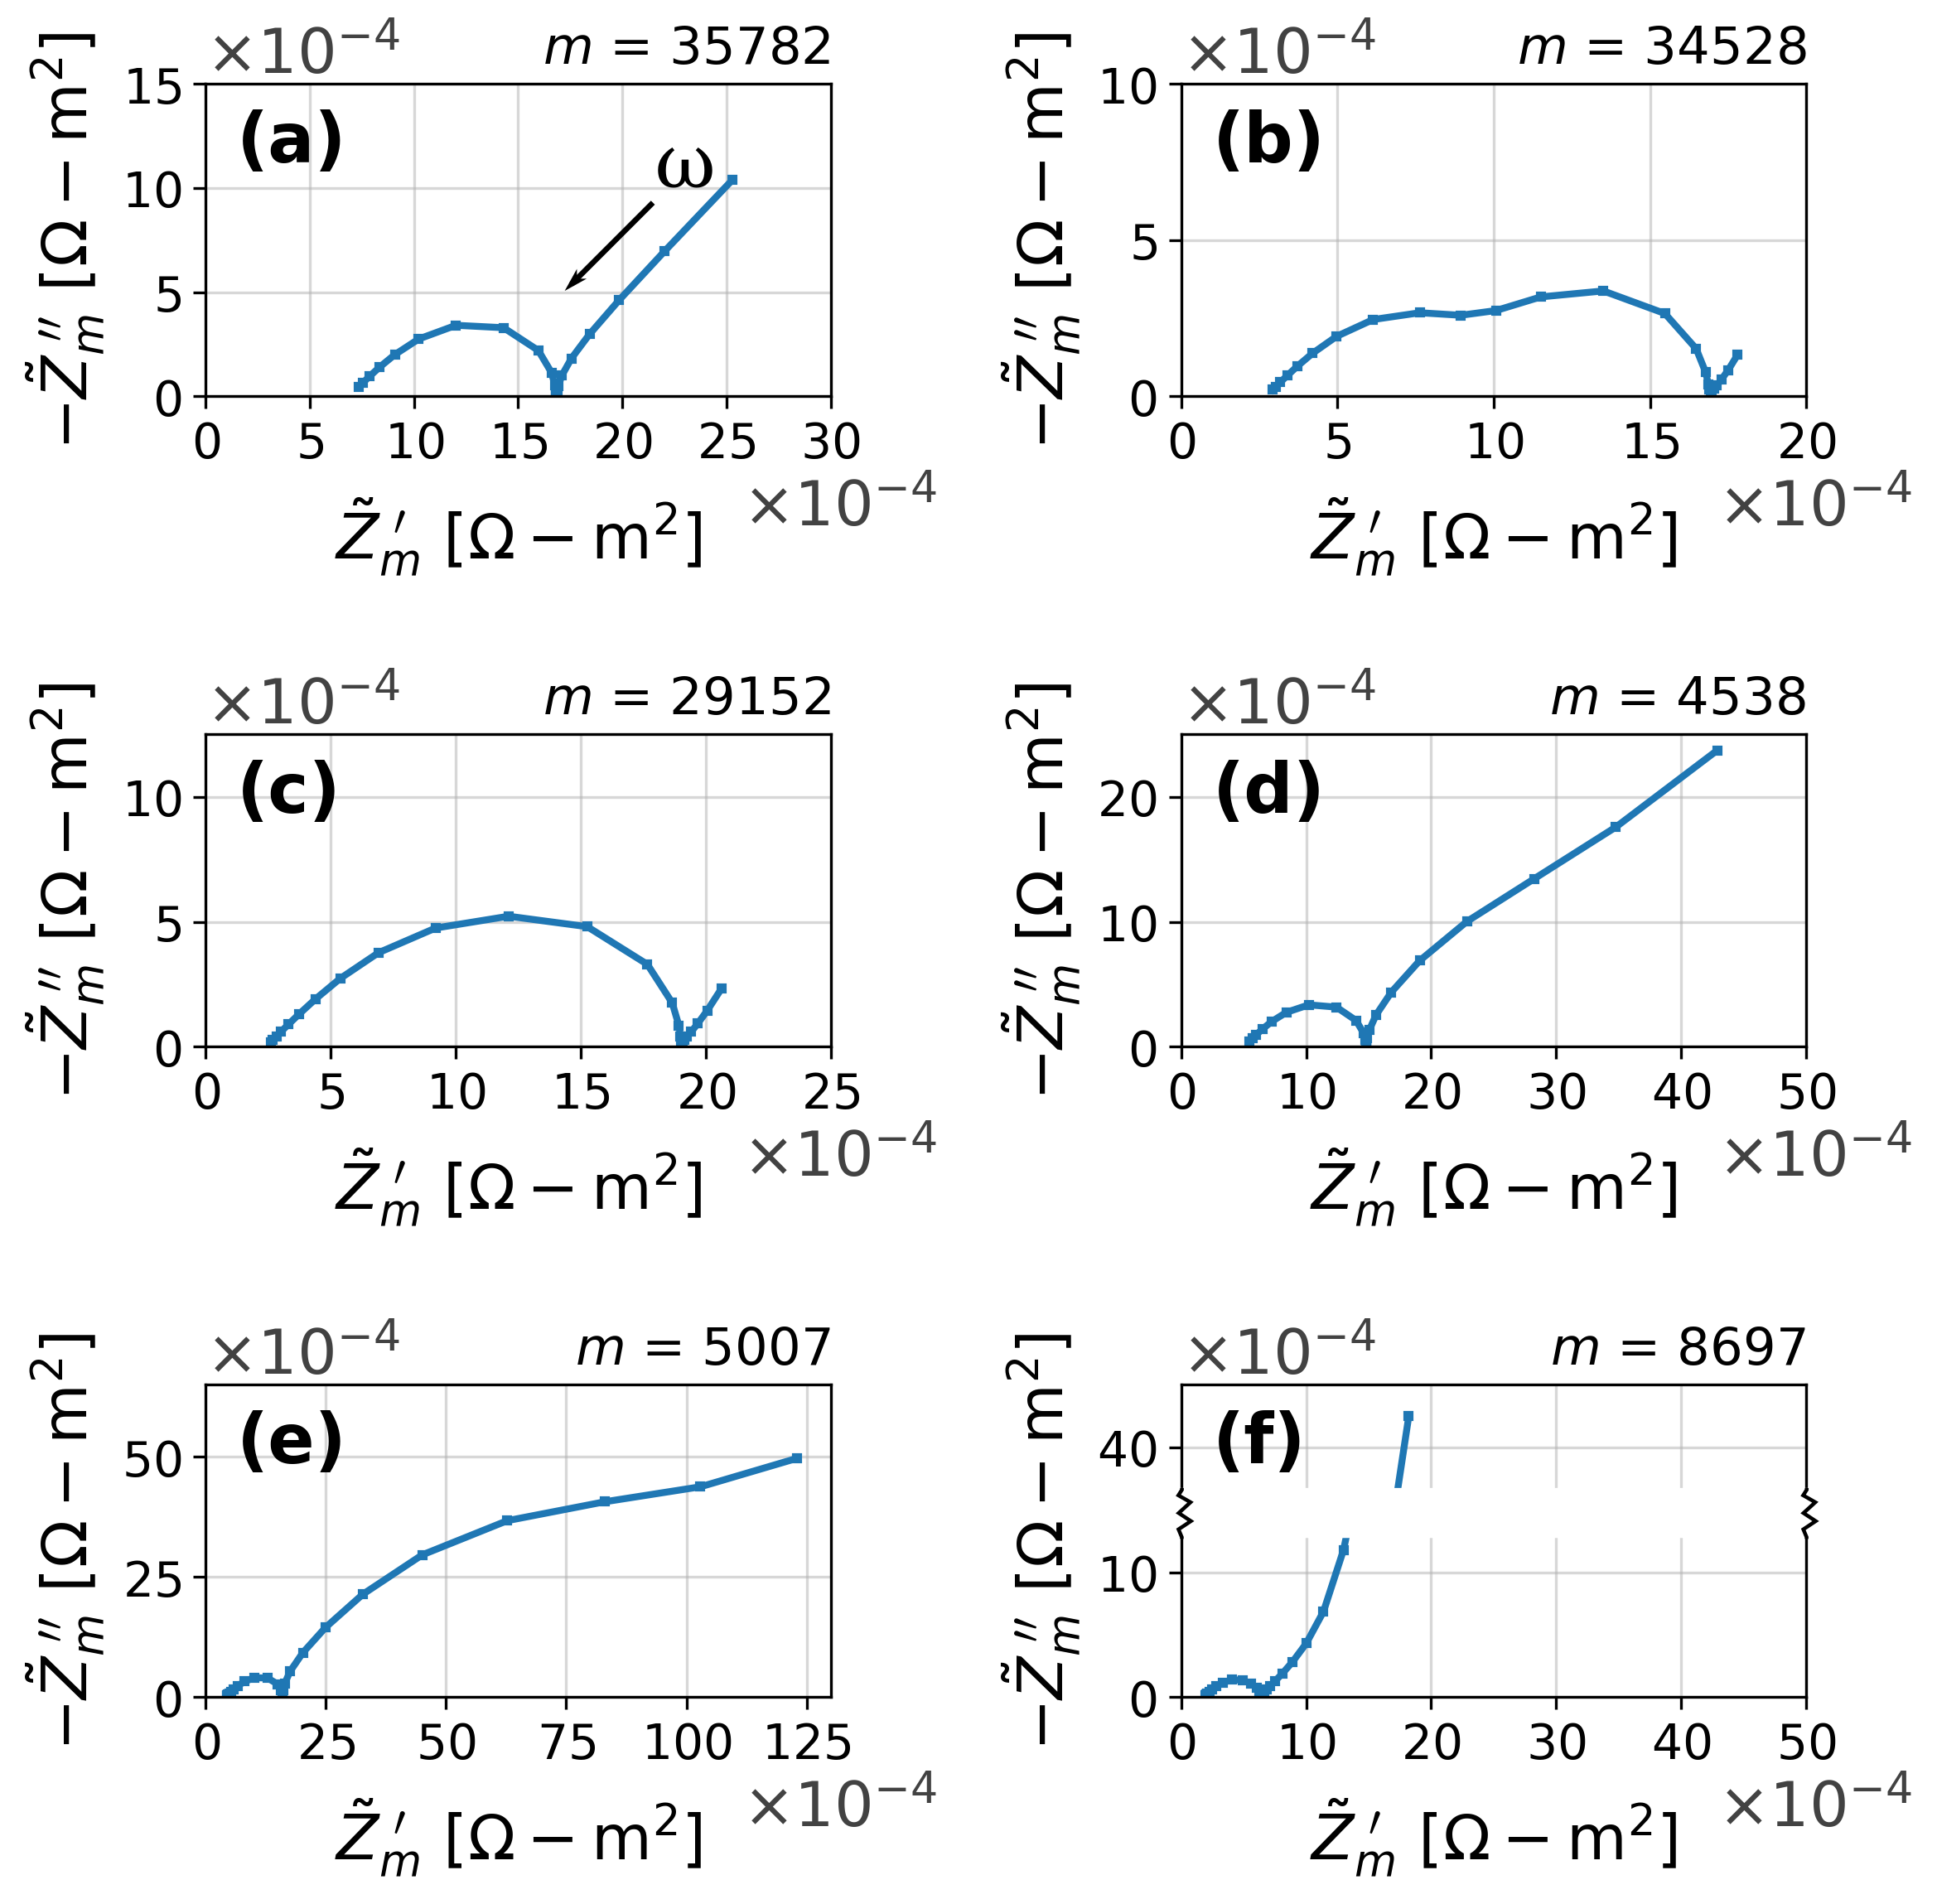

In [9]:
from IPython.display import Image

Image("../figures/Figure 1/Figure1.png", width="50%", embed=True)

## Figure 2. Analytical Limit vs. Simulated High Frequency

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import FixedOrderFormatter

### Read in simulated spectra

In [11]:
Z_csv = pd.read_csv("../supplementary-files/dataset/38800-Z.csv", index_col=0)
    
real = [a for a in Z_csv.columns if 'real' in a]
real_df = Z_csv[real]
real_df.columns = [float(a.split('_real')[0]) for a in real_df.columns]

imag = [a for a in Z_csv.columns if 'imag' in a]
imag_df = Z_csv[imag]
imag_df.columns = [float(a.split('_imag')[0]) for a in imag_df.columns]

Z = real_df + imag_df*1j
    
parameters = pd.read_csv('../supplementary-files/dataset/model_runs.txt', nrows = len(Z))
parameters.index = parameters['run']

In [12]:
def calc_hf(p):
    kappaeff_sep = p['kappa_0[S/m]']*p['epsilon_sep[1]']**4
    kappaeff_pos = p['kappa_0[S/m]']*p['epsilon_pos[1]']**4
    kappaeff_neg = p['kappa_0[S/m]']*p['epsilon_neg[1]']**4

    sigmaeff_pos = p['sigma_pos[S/m]']*(1-p['epsilon_pos[1]']-p['epsilon_f_pos[1]'])**4
    sigmaeff_neg = p['sigma_neg[S/m]']*(1-p['epsilon_neg[1]']-p['epsilon_f_neg[1]'])**4

    R_sep = p['l_sep[m]']/kappaeff_sep
    R_pos = p['l_pos[m]']/(kappaeff_pos + sigmaeff_pos)
    R_neg = p['l_neg[m]']/(kappaeff_neg + sigmaeff_neg)

    R_ohmic = R_sep + R_pos + R_neg
    
    return R_ohmic

def calc_penetration_depth(p, electrode):
    R = 8.314
    T = 298.15
    F = 96487
    
    kappa = p['kappa_0[S/m]']
    sigma = p['sigma_' + electrode + '[S/m]']
    
    Rp = p['Rp_' + electrode + '[m]']
    eps = p['epsilon_' + electrode + '[1]']
    eps_f = p['epsilon_f_' + electrode + '[1]']
    
    a = (3/Rp)*(1-eps-eps_f)
    i0 = p['i0_' + electrode + '[A/m^2]']
    
    kappa_eff = kappa*eps**4
    sigma_eff = sigma*(1-eps-eps_f)**4
    
    l = p['l_' + electrode + '[m]']
    
    return np.sqrt((R*T*kappa_eff*sigma_eff)/(a*i0*F*(kappa_eff+sigma_eff)))/l

predicted = parameters.apply(calc_hf, axis=1)

In [13]:
penetration_depth_neg = parameters.apply(calc_penetration_depth, axis=1, args=['neg'])
penetration_depth_pos = parameters.apply(calc_penetration_depth, axis=1, args=['pos'])

In [14]:
hf_real = Z.loc[:,100000.0].map(np.real)
hf_imag = Z.loc[:,100000.0].map(np.imag)

In [15]:
percent_imag = -hf_imag*100.0/(np.sqrt(hf_imag**2 + hf_real**2))
phase_angle = np.arctan(hf_imag/hf_real)*180/np.pi

In [16]:
deviation = (hf_real.values - predicted.values)/predicted.values
dev_below_10percent = (hf_real[phase_angle > -5.7].values - predicted[phase_angle > -5.7].values)/predicted[phase_angle > -5.7].values

In [17]:
print('Average deviation = {:.2%}'.format(deviation.mean()))
print('Average deviation of close spectra ({:.2%} of all spectra) = {:.2%}'.format(len(np.where(phase_angle > -5.7)[0])/len(phase_angle), dev_below_10percent.mean()))

Average deviation = 12.88%
Average deviation of close spectra (68.45% of all spectra) = 5.03%


In [18]:
outliers = [14083, 3751, 18275, 18276]

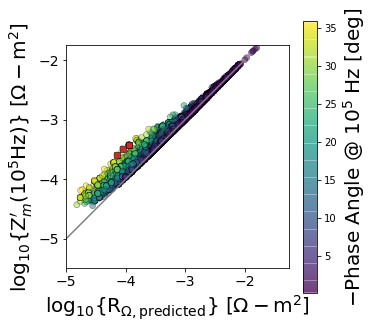

In [19]:
fig3 = plt.figure(3, figsize=(5,5))
ax3 = fig3.add_subplot(111)
plt.plot([-5,-2], [-5,-2], color='gray')
sc = plt.scatter(np.log10(predicted.values), np.log10(hf_real.values), marker='o', edgecolor='black', 
                 linewidths=.5, alpha=.5, c=-phase_angle, cmap='viridis')
plt.scatter(np.log10(predicted.values[outliers]), np.log10(hf_real.values[outliers]), marker='s', edgecolor='black', 
                 linewidths=.5, alpha=1, c='#d62728')
cbar = plt.colorbar(sc)
cbar.set_label(r'$-$Phase Angle @ $10^5$ Hz [deg]', fontsize=20)#\frac{-Z^{\prime\prime}}{|Z|}_{({\omega \rightarrow \infty})} \hspace{.5} [\%] $', fontsize=20)
plt.xlim(-5,-1.25)
plt.ylim(-5.5,-1.75)
plt.xlabel(r'log$_{10}\{$R$_{\Omega, \mathrm{predicted}}\}$ [$\Omega-$m$^2$]', fontsize=20)
plt.ylabel(r'log$_{10}\{$Z$^{\prime}_{m}(10^5 \mathrm{Hz})\}$ [$\Omega-$m$^2$]', fontsize=20)

ax3.set_aspect('equal')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

fig3.savefig('../figures/Figure 2/full.png', dpi=300, bbox_inches='tight', transparent=True)

14083
3751
18275
18276


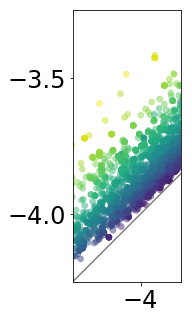

In [20]:
fig4 = plt.figure(4, figsize=(5,5))
ax4 = fig4.add_subplot(111)
plt.plot([-5,-2], [-5,-2], color='gray')
sc = plt.scatter(np.log10(predicted.values), np.log10(hf_real.values), marker='o', 
                 linewidths=.5, alpha=.5, c=percent_imag, cmap='viridis')
# plt.scatter(np.log10(predicted.values[outliers]), np.log10(hf_real.values[outliers]), marker='s', edgecolor='black', 
#                  linewidths=.5, alpha=1, c='red')

for o in outliers:
    
    try:

        data = pd.read_csv('../supplementary-files/full-spectra-data_outliers/harmonics-run-' + str(o + 1) + '.txt', sep = ' ')

        plt.scatter(np.log10(predicted.values[o]), np.log10(data.iloc[0,3]), marker='s', edgecolor='black', s=[100],
                    linewidths=1, alpha=1, c='#d62728')

        plt.scatter(np.log10(predicted.values[o]), np.log10(data.iloc[0,2]), marker='v', edgecolor='black', s=[100],
                    linewidths=1, alpha=1, c='#fdcc8a')

        plt.scatter(np.log10(predicted.values[o]), np.log10(data.iloc[0,1]), marker='v', edgecolor='black', s=[100],
                    linewidths=1, alpha=1, c='#fc8d59')

        plt.scatter(np.log10(predicted.values[o]), np.log10(data.iloc[0,0]), marker='v', edgecolor='black', s=[100],
                    linewidths=1, alpha=1, c='#d7301f')

    except:
        print(o)
            
plt.xlim(-4.25,-3.85)
plt.ylim(-4.25,-3.25)
# plt.xlim(-5.00,-3.50)
# plt.ylim(-4.75,-3.25)
# plt.xlabel(r'log$_{10}($R$_{\Omega, \mathrm{predicted}})$ [$\Omega-$m$^2$]', fontsize=20)
# plt.ylabel(r'log$_{10}($R$_{\Omega, \mathrm{simulated}})$ [$\Omega-$m$^2$]', fontsize=20)

ax4.set_aspect('equal')
ax4.set_xticks([-4.0])
ax4.locator_params(axis='y', nbins=3,tight=True)
ax4.locator_params(axis='x', nbins=1,tight=False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(axis='both', which='major', labelsize=24)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


plt.show()

fig4.savefig('../figures/Figure 2/inset.png', dpi=300, bbox_inches='tight')

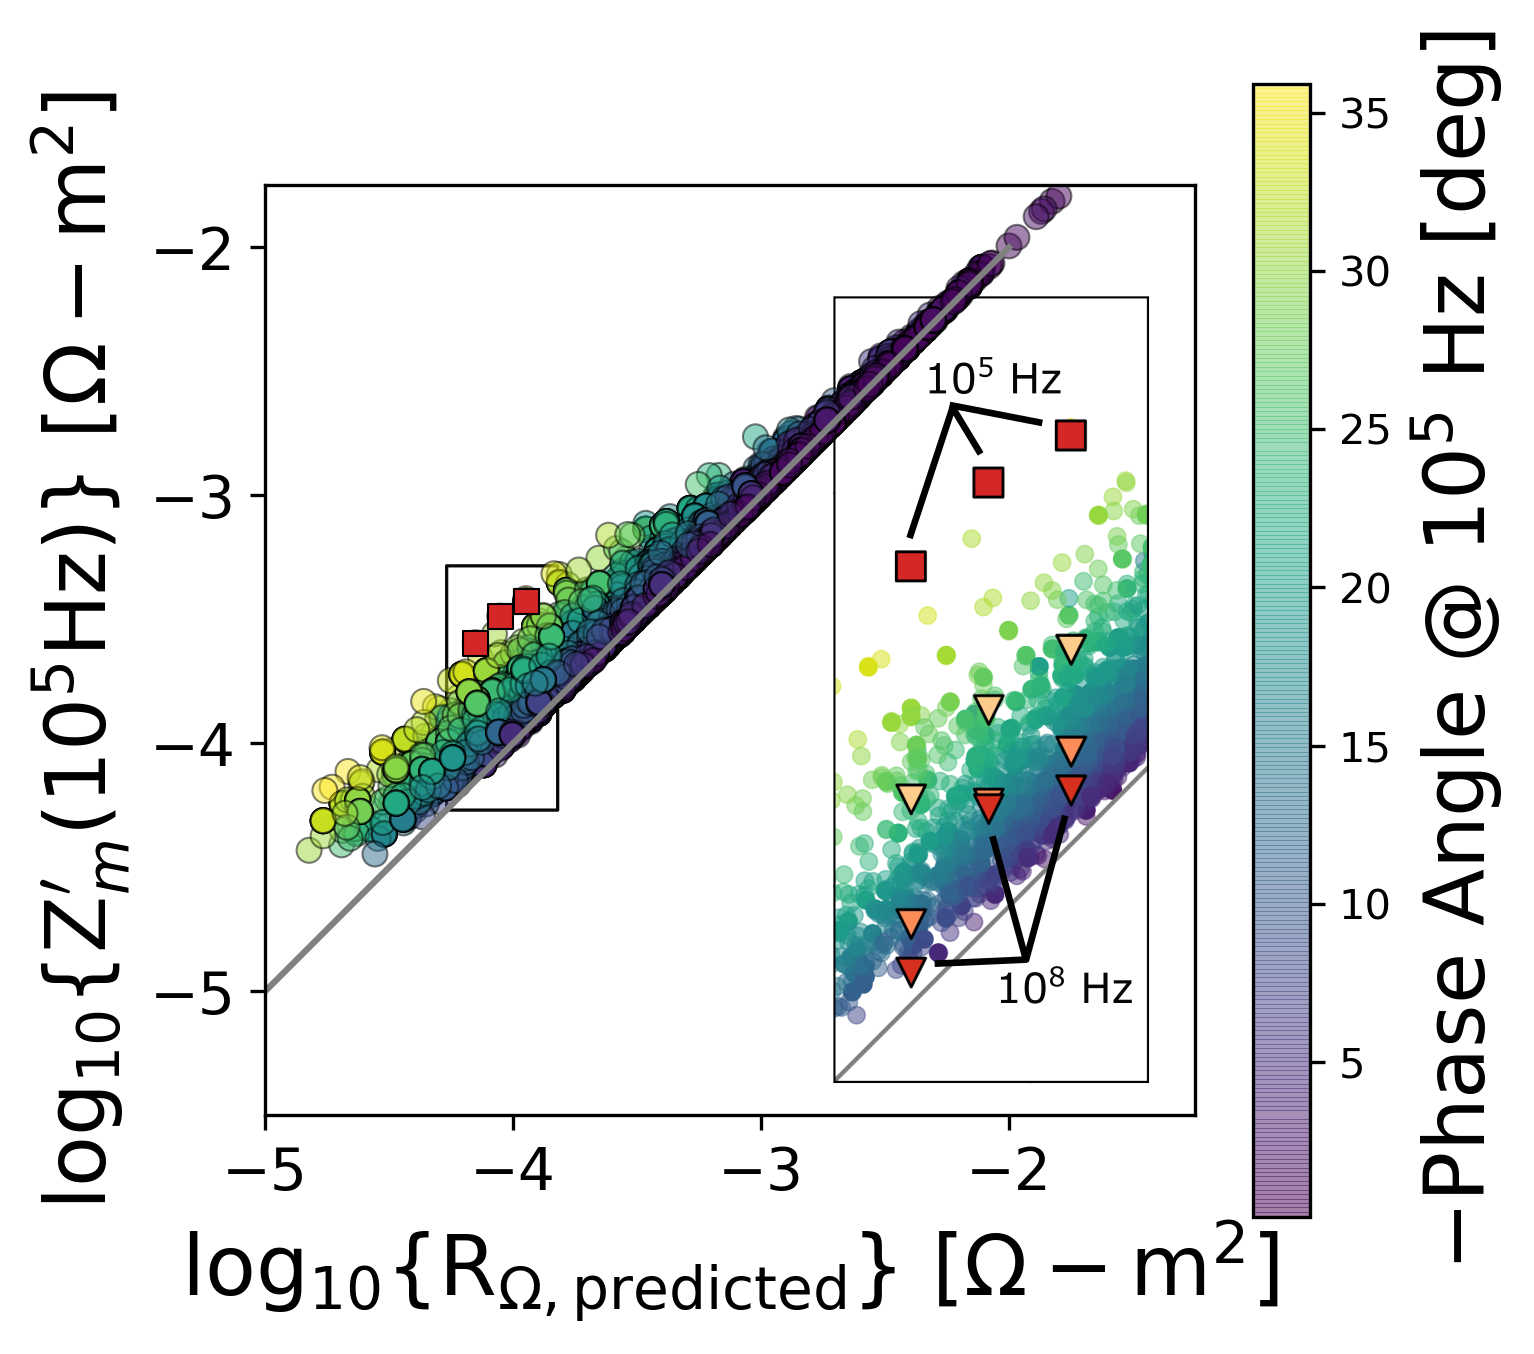

In [21]:
from IPython.display import Image

Image("../figures/Figure 2/Figure2.png", width="50%", embed=True)

## Figure 3. ImpedanceAnalyzer Input Panel

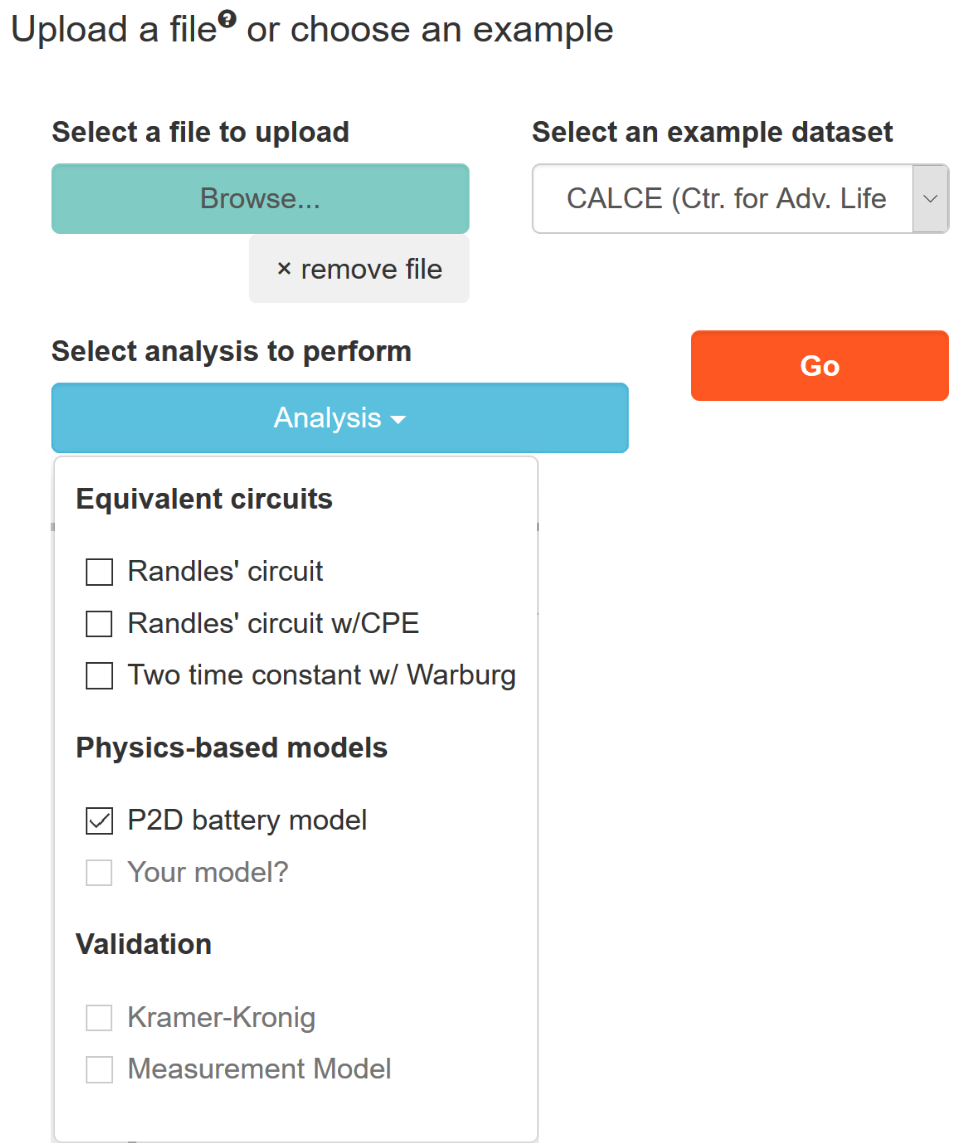

In [22]:
from IPython.display import Image

Image("../figures/Figure 3/Figure3.png", width="50%", embed=True)

## Figure 4. Physics-based Fit Example

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities.plotting import FixedOrderFormatter
from utilities.fitPhysics import fit_P2D_by_capacity

In [24]:
calce_41 = [(0.0125,0.077067327,-0.016325871),(0.025,0.072816877,-0.010852594),(0.0375,0.070902991,-0.009042268),(0.05,0.069793887,-0.007928719),(0.075,0.068356469,-0.006702246),(0.1,0.067539456,-0.005860985),(0.15,0.066499017,-0.004974516),(0.2,0.065896117,-0.004366682),(0.3,0.065126744,-0.003781797),(0.4,0.064668814,-0.003450522),(0.6,0.064074966,-0.003307321),(0.8,0.063730274,-0.003239555),(1.2,0.063181241,-0.003471398),(1.6,0.062763935,-0.003702783),(2.4,0.062075156,-0.004396905),(3.2,0.061481122,-0.004995391),(4.8,0.060361911,-0.006194902),(6.4,0.059324481,-0.007141476),(9.6,0.05739148,-0.008678314),(12.8,0.055686621,-0.009746195),(19.2,0.052833581,-0.011183531),(25.6,0.050525748,-0.012062881),(38.4,0.046894984,-0.013077192),(51.2,0.044135155,-0.013536177),(76.8,0.040069549,-0.01371554),(102.4,0.037260703,-0.013503337),(153.6,0.033533462,-0.012835553),(204.8,0.031141578,-0.012214945),(307.2,0.028083032,-0.011234192),(409.6,0.026113264,-0.010509357),(614.4,0.023591557,-0.009472495),(819.2,0.021979143,-0.008702739),(1228.8,0.01998238,-0.007588766),(1638.4,0.018753498,-0.006783784)]
fit_points, model_fit, results_dataframe = fit_P2D_by_capacity(calce_41, 1500)

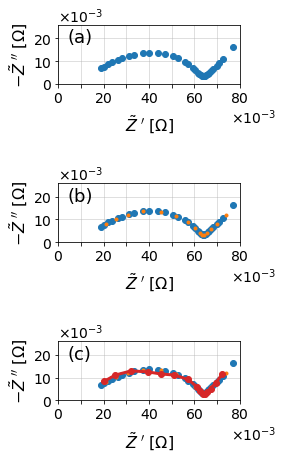

In [25]:
def prep_plot(data):
    f = np.array([x for x, y, z in data])
    r = np.array([y for x, y, z in data])
    i = np.array([z for x, y, z in data])
    return f, r, i

calce_f, calce_r, calce_i = prep_plot(calce_41)
fit_f, fit_r, fit_i = prep_plot(fit_points)
model_f, model_r, model_i = prep_plot(model_fit)

fig3 = plt.figure(figsize=(3.25,8.25))
ax1 = fig3.add_subplot(311)
ax2 = fig3.add_subplot(312)
ax3 = fig3.add_subplot(313)


ax1.plot(calce_r, -calce_i, 'o')

ax2.plot(calce_r, -calce_i, 'o')
ax2.plot(fit_r, -fit_i, '.')

ax3.plot(calce_r, -calce_i, 'o')
ax3.plot(fit_r, -fit_i, '.')
ax3._get_lines.get_next_color()
ax3.plot(model_r, -model_i, 'o-', linewidth=3)

labels = 'abc'
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.text(.05,.7, '('+labels[i]+')', transform=ax.transAxes, fontsize=18)
    ax.set_xlim(0.00,.08)
    ax.set_ylim(0,.026)

    ax.set_xlabel(r'$\tilde{Z}^{\ \prime}$ [$\Omega$]', fontsize=16, labelpad=8)
    ax.set_ylabel(r'$-\tilde{Z}^{\ \prime\prime}$ [$\Omega$]', fontsize=16)

    ax.set_aspect('equal')
    ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
    ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.locator_params(axis='x', nbins=8,tight=True)
    ax.locator_params(axis='y', nbins=3,tight=True)
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % 2 != 0:
            label.set_visible(False)
    ax.grid(b=True, which='major', axis='both', alpha=.5)
    y_offset = ax.yaxis.get_offset_text()
    y_offset.set_size(14)
    t = ax.xaxis.get_offset_text()
    t.set_size(14)
    t.set_position((1.2,0))

plt.show()

fig3.savefig('../figures/Figure 4/Figure4.png', dpi=300, bbox_inches='tight')

In [26]:
print('Run (m): {:.0f}'.format(results_dataframe['run'].iloc[0]))
print('Residual: {:.2f}%'.format(results_dataframe['residual'].iloc[0]))
print('Area: {:.2f} cm^2'.format(results_dataframe['area'].iloc[0]*100**2))
print('Contact Resistance: {:.2f} mOhms'.format(1000*results_dataframe['contact_resistance'].iloc[0]))

Run (m): 6230
Residual: 1.73%
Area: 300.32 cm^2
Contact Resistance: 4.19 mOhms


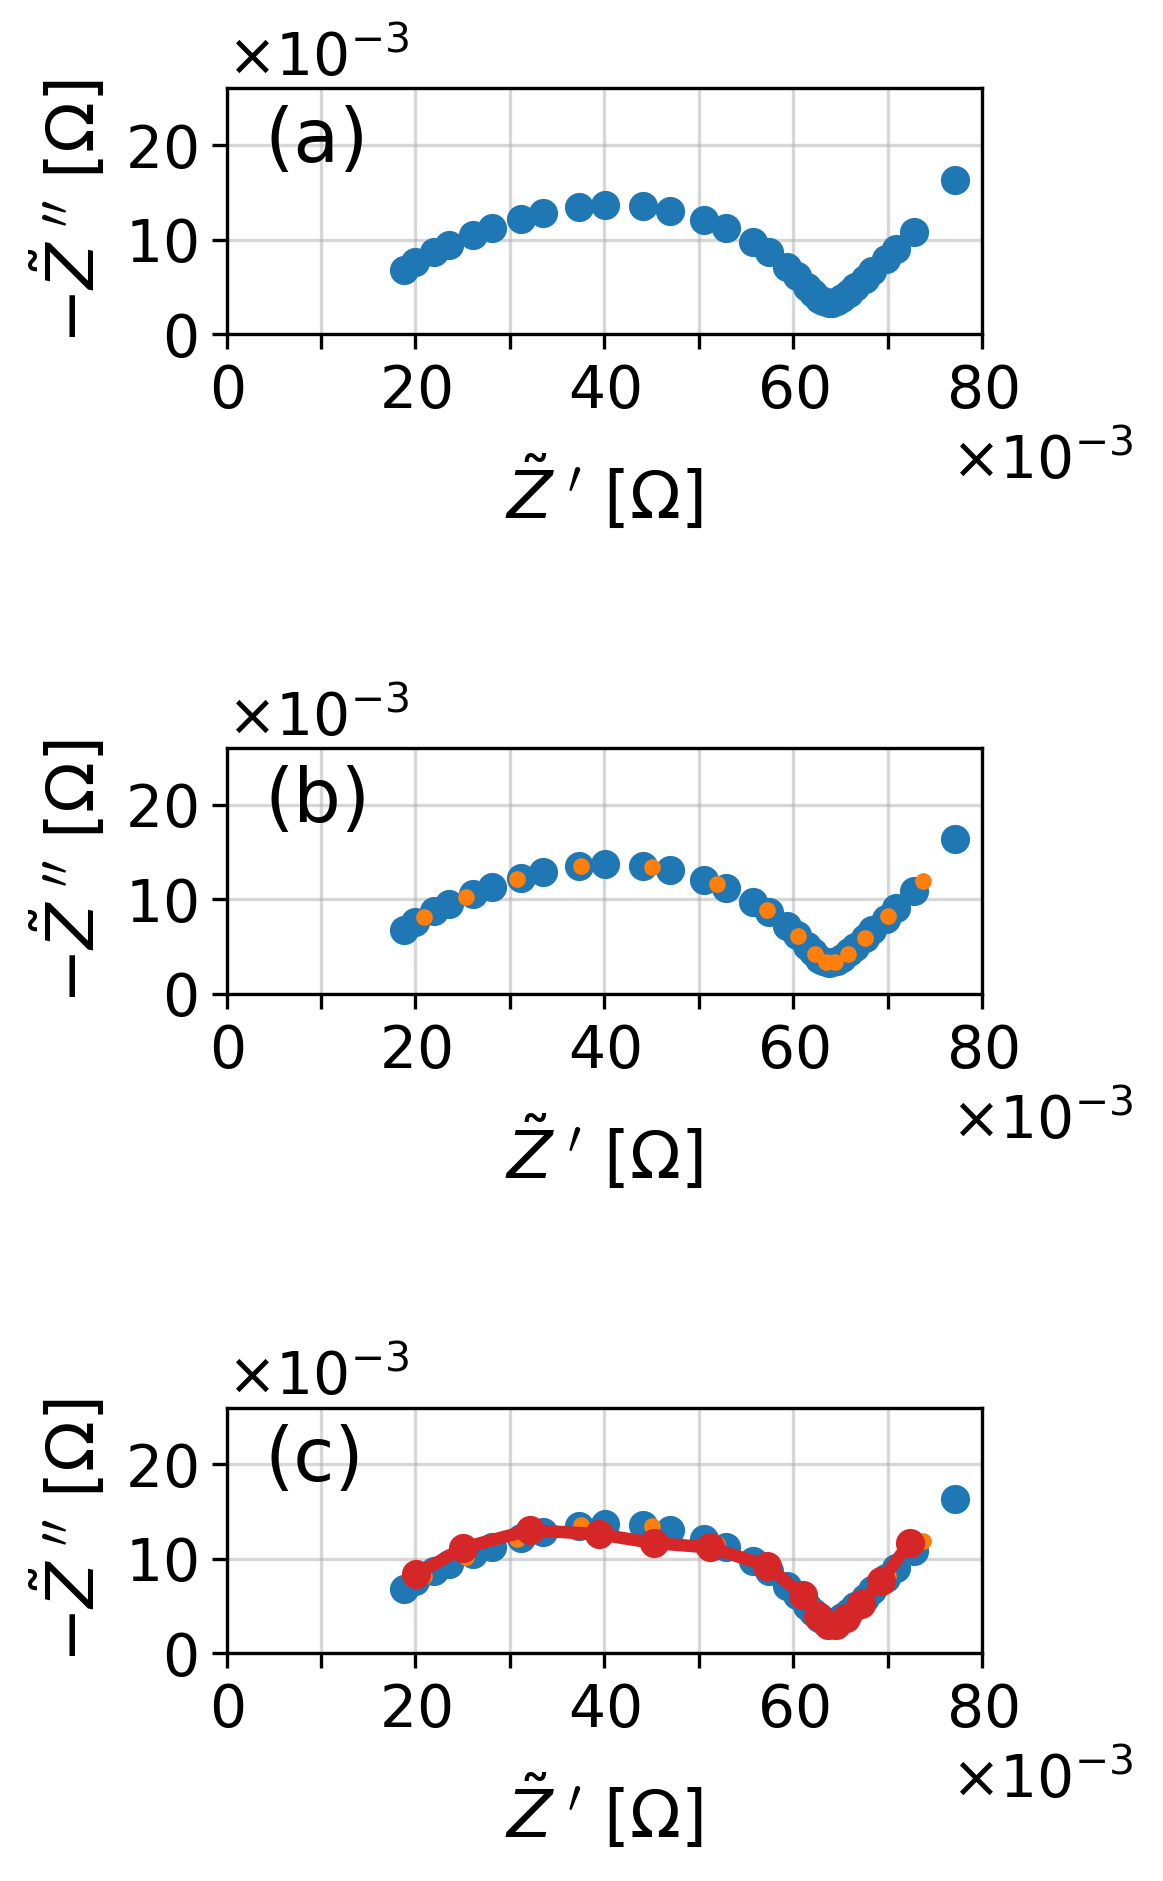

In [27]:
from IPython.display import Image

Image("../figures/Figure 4/Figure4.png", width="25%", embed=True)

## Figures 5 and 6. Explore nearly matching spectra

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities.plotting import FixedOrderFormatter
from utilities.fitPhysics import fit_P2D_by_capacity

In [29]:
calce_41 = [(0.0125,0.077067327,-0.016325871),(0.025,0.072816877,-0.010852594),(0.0375,0.070902991,-0.009042268),(0.05,0.069793887,-0.007928719),(0.075,0.068356469,-0.006702246),(0.1,0.067539456,-0.005860985),(0.15,0.066499017,-0.004974516),(0.2,0.065896117,-0.004366682),(0.3,0.065126744,-0.003781797),(0.4,0.064668814,-0.003450522),(0.6,0.064074966,-0.003307321),(0.8,0.063730274,-0.003239555),(1.2,0.063181241,-0.003471398),(1.6,0.062763935,-0.003702783),(2.4,0.062075156,-0.004396905),(3.2,0.061481122,-0.004995391),(4.8,0.060361911,-0.006194902),(6.4,0.059324481,-0.007141476),(9.6,0.05739148,-0.008678314),(12.8,0.055686621,-0.009746195),(19.2,0.052833581,-0.011183531),(25.6,0.050525748,-0.012062881),(38.4,0.046894984,-0.013077192),(51.2,0.044135155,-0.013536177),(76.8,0.040069549,-0.01371554),(102.4,0.037260703,-0.013503337),(153.6,0.033533462,-0.012835553),(204.8,0.031141578,-0.012214945),(307.2,0.028083032,-0.011234192),(409.6,0.026113264,-0.010509357),(614.4,0.023591557,-0.009472495),(819.2,0.021979143,-0.008702739),(1228.8,0.01998238,-0.007588766),(1638.4,0.018753498,-0.006783784)]
fit_points, model_fit, results_dataframe = fit_P2D_by_capacity(calce_41, 1500)

In [30]:
def prep_plot(data):
    f = np.array([x for x, y, z in data])
    r = np.array([y for x, y, z in data])
    i = np.array([z for x, y, z in data])
    return f, r, i

calce_f, calce_r, calce_i = prep_plot(calce_41)
fit_f, fit_r, fit_i = prep_plot(fit_points)
model_f, model_r, model_i = prep_plot(model_fit)

In [31]:
Z_csv = pd.read_csv("../supplementary-files/dataset/38800-Z.csv", index_col=0)
    
real = [a for a in Z_csv.columns if 'real' in a]
real_df = Z_csv[real]
real_df.columns = [float(a.split('_real')[0]) for a in real_df.columns]

imag = [a for a in Z_csv.columns if 'imag' in a]
imag_df = Z_csv[imag]
imag_df.columns = [float(a.split('_imag')[0]) for a in imag_df.columns]

Z = real_df + imag_df*1j

Rank: 3, Run (m): 34560
Rank: 7, Run (m): 4932
Rank: 10, Run (m): 32014


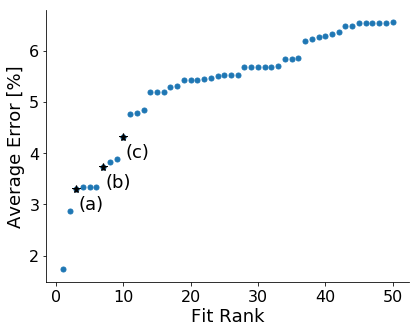

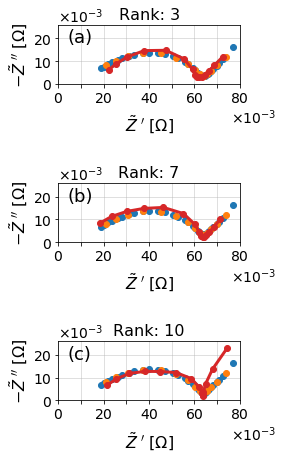

In [32]:
plot_dict = [{'rank': 2, 'axes': [.22,.2,.24,.14]}, 
             {'rank': 6, 'axes': [.17,.75,.24,.14]},
             {'rank': 9, 'axes': [.6,.55,.24,.14]}]

fig5 = plt.figure(figsize=(6.5, 5))
ax5 = fig5.add_subplot(111)
blue_dot, = plt.plot(range(1,51),results_dataframe['residual'].values, 'o', markersize=5, color='#1f77b4')
plt.xlabel('Fit Rank', fontsize=18)
plt.ylabel('Average Error [%]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

fig6 = plt.figure(figsize=(3.25,8.25))
ax61 = fig6.add_subplot(311)
ax62 = fig6.add_subplot(312)
ax63 = fig6.add_subplot(313)

indexes = []
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate([ax61, ax62, ax63]):
    
    subplot = plot_dict[i]
    
    index = subplot['rank']
    indexes.append(index)

    ax.plot(calce_r, -calce_i, 'o', label = 'experimental data')
    orange_s, = ax.plot(fit_r, -fit_i, 'o', label = 'points to fit')

    run = int(results_dataframe['run'].iloc[index])
    area = results_dataframe['area'].iloc[index]
    contact_resistance = results_dataframe['contact_resistance'].iloc[index]
    Zr = Z.loc[run][fit_f].map(np.real)/area + contact_resistance
    Zi = Z.loc[run][fit_f].map(np.imag)/area

    ax._get_lines.get_next_color()
    red_line, = ax.plot(Zr, -Zi,'o-', linewidth=3)
    ax.set_title('Rank: ' + str(index + 1), fontsize=16, verticalalignment='baseline')

    ax5.plot(index+1, results_dataframe['residual'].iloc[index], '*', color='black', markersize=8, zorder=10)
    ax5.text(index+1.3, results_dataframe['residual'].iloc[index] - .3, labels[i], fontsize=18, va='center', ha='left')
    
    print('Rank: {:.0f}, Run (m): {:.0f}'.format(index + 1, run))
    
for i, ax in enumerate([ax61, ax62, ax63]):
    ax.text(.05,.7, labels[i], transform=ax.transAxes, fontsize=18)
    ax.set_xlim(0.00,.08)
    ax.set_ylim(0,.026)

    ax.set_xlabel(r'$\tilde{Z}^{\ \prime}$ [$\Omega$]', fontsize=16, labelpad=8)
    ax.set_ylabel(r'$-\tilde{Z}^{\ \prime\prime}$ [$\Omega$]', fontsize=16)

    ax.set_aspect('equal')
    ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
    ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.locator_params(axis='x', nbins=8,tight=True)
    ax.locator_params(axis='y', nbins=3,tight=True)
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % 2 != 0:
            label.set_visible(False)
    ax.grid(b=True, which='major', axis='both', alpha=.5)
    y_offset = ax.yaxis.get_offset_text()
    y_offset.set_size(14)
    t = ax.xaxis.get_offset_text()
    t.set_size(14)
    t.set_position((1.2,0))
    
plt.show()

fig5.savefig('../figures/Figure 5/Figure5.png', dpi=300, bbox_inches='tight')
fig6.savefig('../figures/Figure 6/Figure6.png', dpi=300, bbox_inches='tight')

#### Look at errors vs frequency

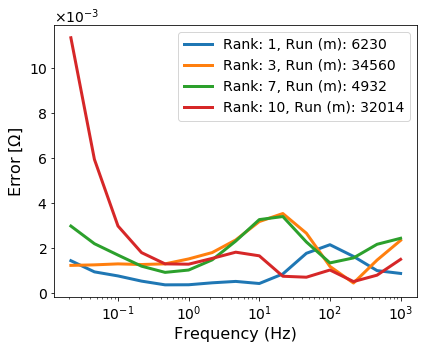

In [33]:
plot_dict = [{'rank': 0, 'axes': [.22,.2,.24,.14]},
             {'rank': 2, 'axes': [.22,.2,.24,.14]}, 
             {'rank': 6, 'axes': [.17,.75,.24,.14]},
             {'rank': 9, 'axes': [.6,.55,.24,.14]}]

fig7 = plt.figure(figsize=(6.5,5))
ax7 = fig7.add_subplot(111)

indexes = []
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(plot_dict):
    
    subplot = plot_dict[i]
    
    index = subplot['rank']
    indexes.append(index)

    run = int(results_dataframe['run'].iloc[index])
    area = results_dataframe['area'].iloc[index]
    contact_resistance = results_dataframe['contact_resistance'].iloc[index]
    Zr = Z.loc[run][fit_f].map(np.real)/area + contact_resistance
    Zi = Z.loc[run][fit_f].map(np.imag)/area
    
    residual = np.abs(Z.loc[run][fit_f]/area + contact_resistance - (fit_r + 1j*fit_i))
    ax7.plot(fit_f, residual, linewidth=3, label='Rank: {:.0f}, Run (m): {:.0f}'.format(index + 1, run))
        
ax7.set_xscale('log')
# ax7.set_yscale('log')

ax7.legend(loc='best', fontsize=14)
ax7.set_xlabel('Frequency (Hz)', fontsize=16)
ax7.set_ylabel('Error [$\Omega$]', fontsize=16)
ax7.tick_params(axis='both', which='major', labelsize=14)
ax7.yaxis.set_major_formatter(FixedOrderFormatter(-3))
y_offset = ax7.yaxis.get_offset_text()
y_offset.set_size(14)
    
plt.show()

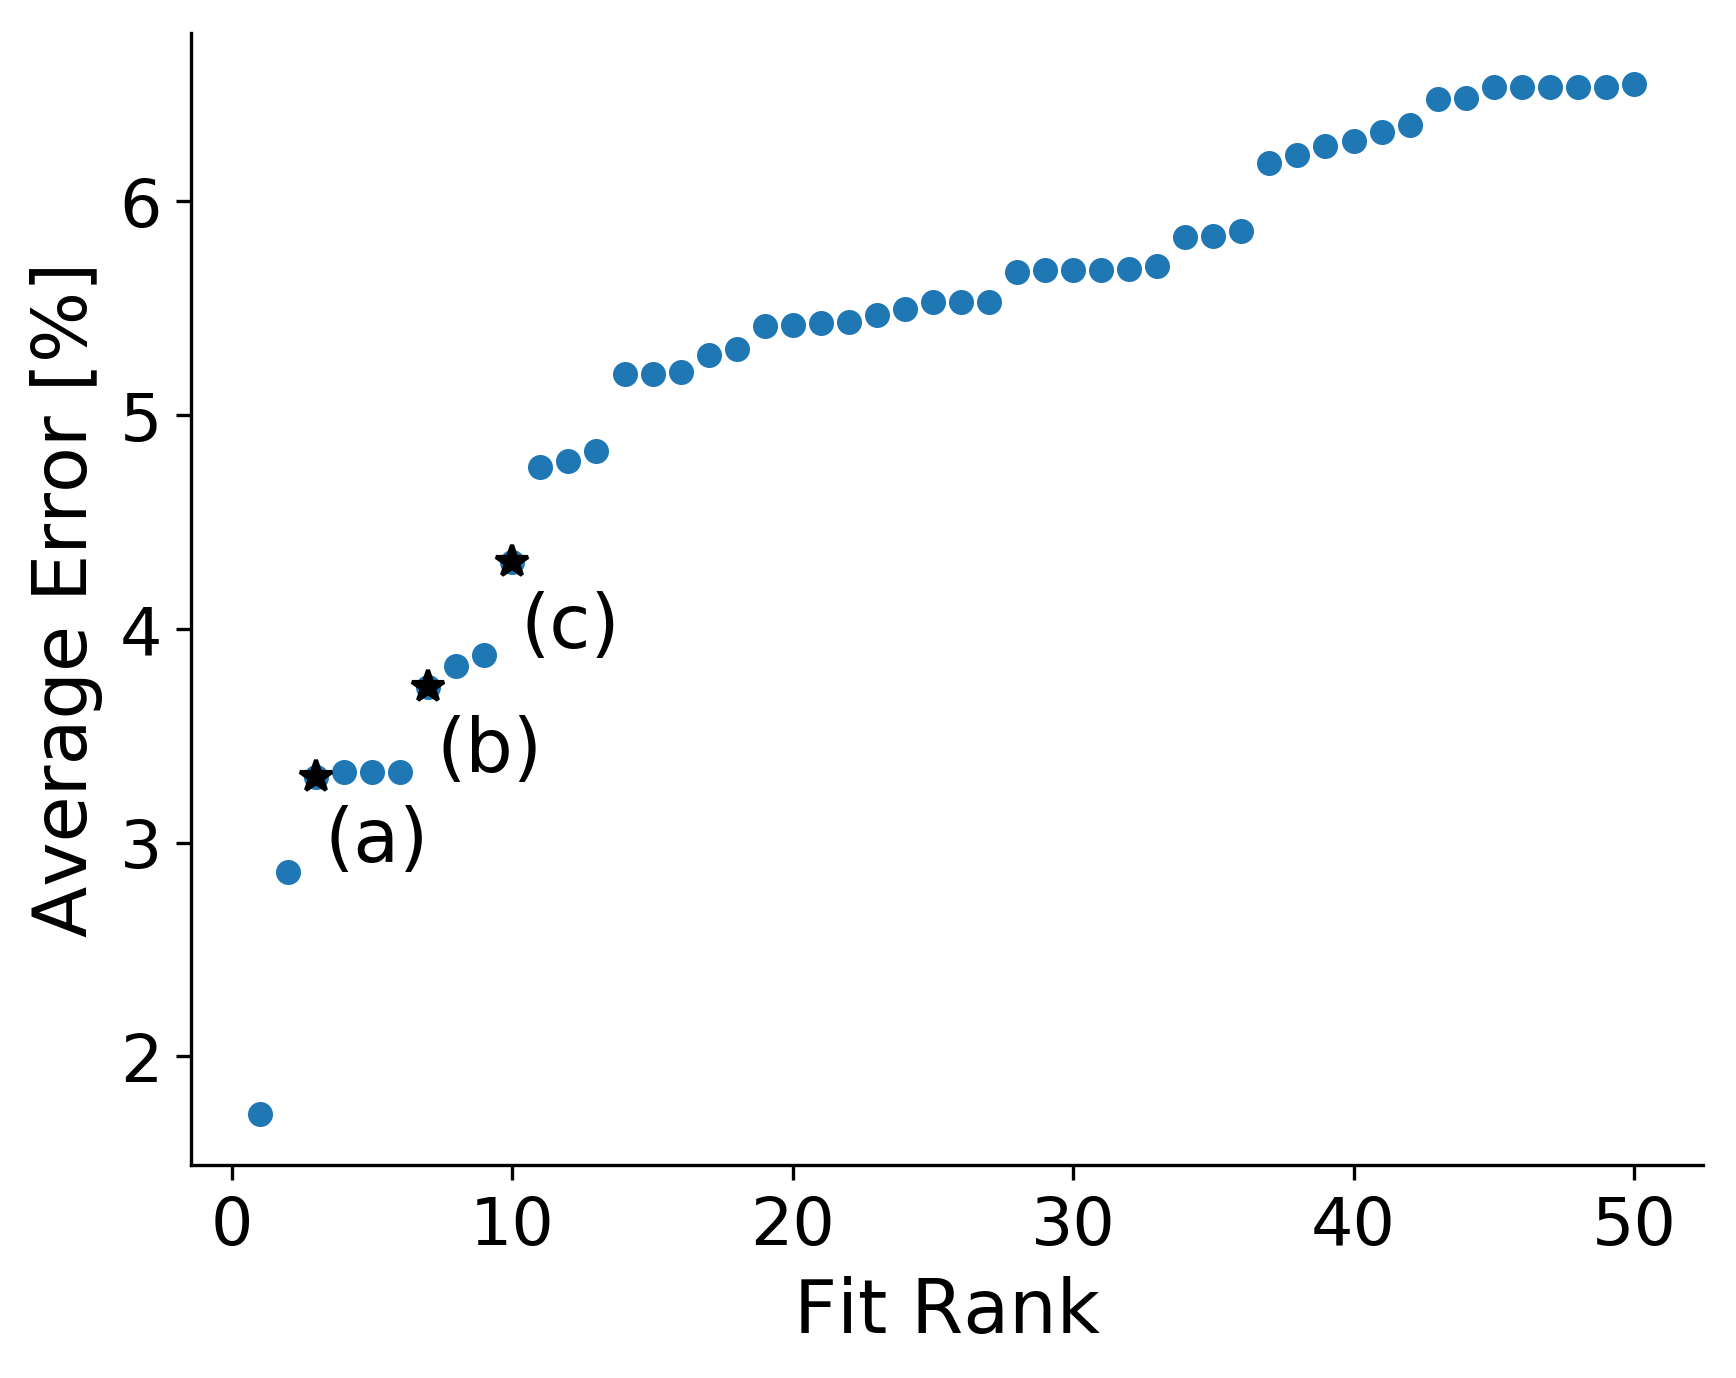

In [34]:
from IPython.display import Image

Image("../figures/Figure 5/Figure5.png", width="50%", embed=True)

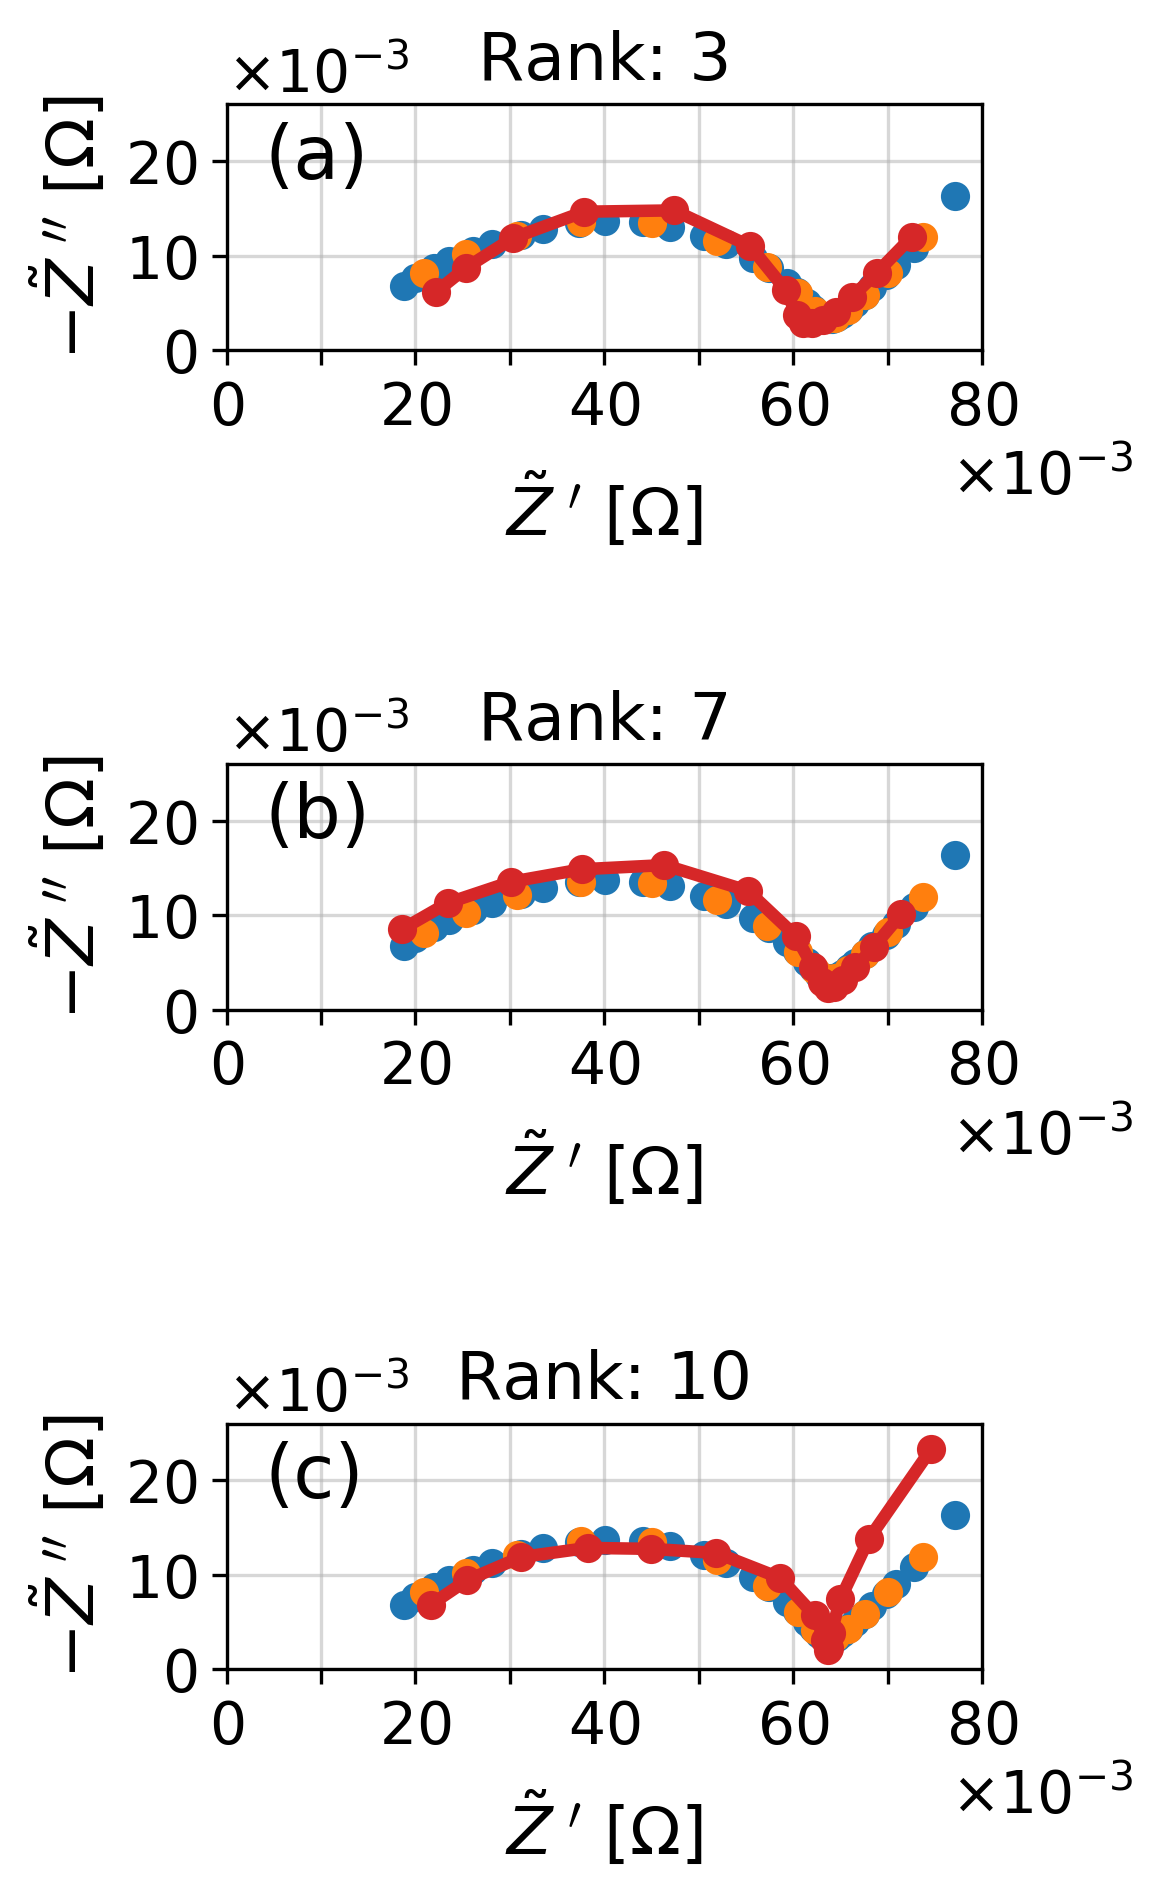

In [35]:
Image("../figures/Figure 6/Figure6.png", width="25%", embed=True)

## Figure 7. Local Optimization of Single Parameters

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities.plotting import FixedOrderFormatter
from utilities.fitPhysics import fit_P2D_by_capacity

In [37]:
calce_41 = [(0.0125,0.077067327,-0.016325871),(0.025,0.072816877,-0.010852594),(0.0375,0.070902991,-0.009042268),(0.05,0.069793887,-0.007928719),(0.075,0.068356469,-0.006702246),(0.1,0.067539456,-0.005860985),(0.15,0.066499017,-0.004974516),(0.2,0.065896117,-0.004366682),(0.3,0.065126744,-0.003781797),(0.4,0.064668814,-0.003450522),(0.6,0.064074966,-0.003307321),(0.8,0.063730274,-0.003239555),(1.2,0.063181241,-0.003471398),(1.6,0.062763935,-0.003702783),(2.4,0.062075156,-0.004396905),(3.2,0.061481122,-0.004995391),(4.8,0.060361911,-0.006194902),(6.4,0.059324481,-0.007141476),(9.6,0.05739148,-0.008678314),(12.8,0.055686621,-0.009746195),(19.2,0.052833581,-0.011183531),(25.6,0.050525748,-0.012062881),(38.4,0.046894984,-0.013077192),(51.2,0.044135155,-0.013536177),(76.8,0.040069549,-0.01371554),(102.4,0.037260703,-0.013503337),(153.6,0.033533462,-0.012835553),(204.8,0.031141578,-0.012214945),(307.2,0.028083032,-0.011234192),(409.6,0.026113264,-0.010509357),(614.4,0.023591557,-0.009472495),(819.2,0.021979143,-0.008702739),(1228.8,0.01998238,-0.007588766),(1638.4,0.018753498,-0.006783784)]
fit_points, model_fit, results_dataframe = fit_P2D_by_capacity(calce_41, 1500)

In [38]:
index = int(results_dataframe['run'].iloc[0])
area = results_dataframe['area'].iloc[0]
contact_resistance = results_dataframe['contact_resistance'].iloc[0]

Residual error: 1.73


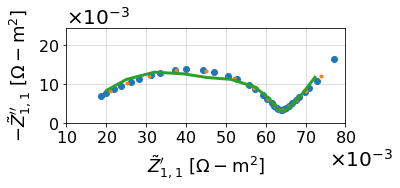

In [39]:
def prep_plot(data):
    f = np.array([x for x, y, z in data])
    r = np.array([y for x, y, z in data])
    i = np.array([z for x, y, z in data])
    return f, r, i

calce_f, calce_r, calce_i = prep_plot(calce_41)
fit_f, fit_r, fit_i = prep_plot(fit_points)
model_f, model_r, model_i = prep_plot(model_fit)

print('Residual error: {:.2f}'.format(results_dataframe['residual'].iloc[0]))

fig3 = plt.figure(figsize=(5,1.75))
ax = fig3.add_subplot(111)

plt.plot(calce_r, -calce_i, 'o')
plt.plot(fit_r, -fit_i, '.')
plt.plot(model_r, -model_i, '-', linewidth=3)
# plt.plot((predicted.values[index] + contact_resistance)/area, 0, 'o')
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

plt.show()

### Read in base parameters

In [40]:
parameters = pd.read_csv('../supplementary-files/dataset/model_runs.txt')
parameters.index = parameters['run']
base_run = int(results_dataframe['run'].iloc[0])
base_scale = results_dataframe['area'].iloc[0]
contact_resistance = results_dataframe.iloc[0]['contact_resistance']
base_parameters = parameters.loc[base_run]

### Swing Tail with $D_{s}$ and $\frac{\partial U}{\partial c_s}$

In [41]:
print('Ds_neg', base_parameters['Ds_neg[m^2/s]'], 'm^2/s')
print('Ds_pos', base_parameters['Ds_pos[m^2/s]'], 'm^2/s')

Ds_neg 9.08858124329e-12 m^2/s
Ds_pos 4.33717585354e-16 m^2/s


In [42]:
# base = base_parameters.copy()
# base['run'] = 'basecase'
# run_list = run_list.append(base, ignore_index=True)

D_mult = np.linspace(.1,.9, num=8, endpoint=False)

for d in ['Ds_neg[m^2/s]', 'Ds_pos[m^2/s]']:

    run_list = pd.DataFrame(columns = parameters.columns)

    for m in D_mult:

        new_params = base_parameters.copy()
        new_params['run'] = d.split('[')[0] + str(m)
        new_params[d] = base_parameters[d]*m
        run_list = run_list.append(new_params, ignore_index=True)

    run_list.sort_index(ascending=False).to_csv('../supplementary-files/local-optimization/inputs/sweep_' + d.split('[')[0] + '.csv', index=False, index_label=False)

#### $D_{s, neg}$

Ds_neg0.1, residual = 3.27%
Ds_neg0.2, residual = 2.23%
Ds_neg0.3, residual = 1.76%
Ds_neg0.4, residual = 1.50%
Ds_neg0.5, residual = 1.38%
Ds_neg0.6, residual = 1.45%
Ds_neg0.7, residual = 1.54%
Ds_neg0.8, residual = 1.61%


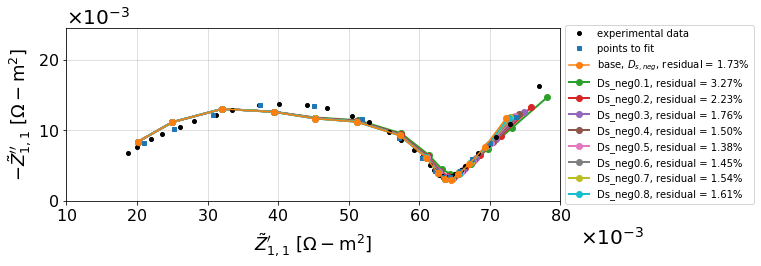

In [43]:
import os
fig = plt.figure(4,figsize=(12,4))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data', markersize=4, color='black', zorder=10)
plt.plot(fit_r, -fit_i, 's', label = 'points to fit', markersize=4, zorder=10)

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))

plt.plot(model_r, -model_i, 'o-', zorder=10, label = r'base, $D_{s,neg}$' + ', residual = {:.2%}'.format(residual/avg_mag))# = -2.67 $\frac{V cm^3}{mol}$', linewidth=3)

directory = '../supplementary-files/local-optimization/outputs/sweep_Ds_neg/'
for filename in os.listdir(directory):
    run_name = filename.split('spectra-')[1].split('.txt')[0]

    if 'base' not in run_name:
        data = pd.read_csv(directory + filename, sep = ' ')
        data.columns = [str(float(f)) for f in data.columns]

        mask = [str(f) for f in fit_f]

        Zr = data.loc[0,mask]/base_scale + contact_resistance
        Zi = data.loc[1,mask]/base_scale

        scaled = Zr.values + 1j*Zi.values
        Z11_exp = fit_r + 1j*fit_i
        avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

        residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

        print(run_name + ', residual = {:.2%}'.format(residual/avg_mag))
        plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=2)
    
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

fig.savefig('../supplementary-files/local-optimization/figures/sweep_Ds_neg.png', dpi=300, bbox_inches='tight')

#### $D_{s,pos}$

Ds_pos0.1, residual = 6.35%
Ds_pos0.2, residual = 4.15%
Ds_pos0.3, residual = 3.07%
Ds_pos0.4, residual = 2.40%
Ds_pos0.5, residual = 1.94%
Ds_pos0.6, residual = 1.62%
Ds_pos0.7, residual = 1.41%
Ds_pos0.8, residual = 1.44%


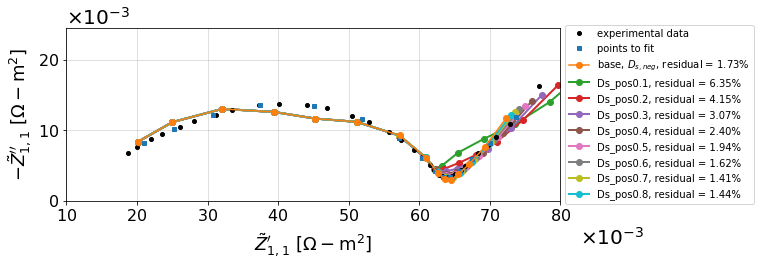

In [44]:
import os
fig = plt.figure(4,figsize=(12,4))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data', markersize=4, color='black', zorder=10)
plt.plot(fit_r, -fit_i, 's', label = 'points to fit', markersize=4, zorder=10)

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))

plt.plot(model_r, -model_i, 'o-', zorder=10, label = r'base, $D_{s,neg}$' + ', residual = {:.2%}'.format(residual/avg_mag))# = -2.67 $\frac{V cm^3}{mol}$', linewidth=3)

directory = '../supplementary-files/local-optimization/outputs/sweep_Ds_pos/'
for filename in os.listdir(directory):
    run_name = filename.split('spectra-')[1].split('.txt')[0]

    if 'base' not in run_name:
        data = pd.read_csv(directory + filename, sep = ' ')
        data.columns = [str(float(f)) for f in data.columns]

        mask = [str(f) for f in fit_f]

        Zr = data.loc[0,mask]/base_scale + contact_resistance
        Zi = data.loc[1,mask]/base_scale

        scaled = Zr.values + 1j*Zi.values
        Z11_exp = fit_r + 1j*fit_i
        avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

        residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

        print(run_name + ', residual = {:.2%}'.format(residual/avg_mag))
        plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=2)
    
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

fig.savefig('../supplementary-files/local-optimization/figures/sweep_Ds_pos.png', dpi=300, bbox_inches='tight')

In [45]:
print('dUdcp_neg', base_parameters['dUdcp_neg[V*cm^3/mol]'], 'V*cm^3/mol')
print('dUdcp_pos', base_parameters['dUdcp_pos[V*cm^3/mol]'], 'V*cm^3/mol')

dUdcp_neg -40.4969088913 V*cm^3/mol
dUdcp_pos -9.60333049054 V*cm^3/mol


In [46]:
dUdcp_mult = np.linspace(2,0, num=9, endpoint=True)

for d in ['dUdcp_neg[V*cm^3/mol]', 'dUdcp_pos[V*cm^3/mol]']:

    run_list = pd.DataFrame(columns = parameters.columns)

    for m in dUdcp_mult:

        new_params = base_parameters.copy()
        new_params['run'] = d.split('[')[0] + str(m)
        new_params[d] = base_parameters[d]*m
        run_list = run_list.append(new_params, ignore_index=True)

    run_list.sort_index(ascending=False).to_csv('../supplementary-files/local-optimization/inputs/sweep_' + d.split('[')[0] + '.csv', index=False, index_label=False)

dUdcp_neg0.0, residual = 3.13%
dUdcp_neg0.25, residual = 2.76%
dUdcp_neg0.5, residual = 2.39%
dUdcp_neg0.75, residual = 2.04%
dUdcp_neg1.0, residual = 1.73%
dUdcp_neg1.25, residual = 1.53%
dUdcp_neg1.5, residual = 1.63%
dUdcp_neg1.75, residual = 1.94%
dUdcp_neg2.0, residual = 2.28%


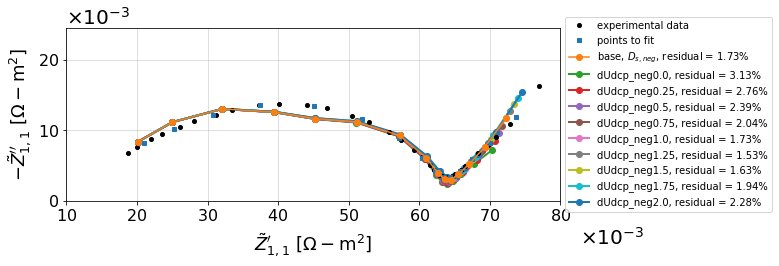

In [47]:
import os
fig = plt.figure(4,figsize=(12,4))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data', markersize=4, color='black', zorder=10)
plt.plot(fit_r, -fit_i, 's', label = 'points to fit', markersize=4, zorder=10)

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))

plt.plot(model_r, -model_i, 'o-', zorder=10, label = r'base, $D_{s,neg}$' + ', residual = {:.2%}'.format(residual/avg_mag))# = -2.67 $\frac{V cm^3}{mol}$', linewidth=3)

directory = '../supplementary-files/local-optimization/outputs/sweep_dUdcp_neg/'
for filename in os.listdir(directory):
    run_name = filename.split('spectra-')[1].split('.txt')[0]

    if 'base' not in run_name:
        data = pd.read_csv(directory + filename, sep = ' ')
        data.columns = [str(float(f)) for f in data.columns]

        mask = [str(f) for f in fit_f]

        Zr = data.loc[0,mask]/base_scale + contact_resistance
        Zi = data.loc[1,mask]/base_scale

        scaled = Zr.values + 1j*Zi.values
        Z11_exp = fit_r + 1j*fit_i
        avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

        residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

        print(run_name + ', residual = {:.2%}'.format(residual/avg_mag))
        plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=2)
    
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

fig.savefig('../supplementary-files/local-optimization/figures/sweep_dudcp_neg.png', dpi=300, bbox_inches='tight')

dUdcp_pos0.0, residual = 5.14%
dUdcp_pos0.25, residual = 4.21%
dUdcp_pos0.5, residual = 3.32%
dUdcp_pos0.75, residual = 2.49%
dUdcp_pos1.0, residual = 1.73%
dUdcp_pos1.25, residual = 1.57%
dUdcp_pos1.5, residual = 2.28%
dUdcp_pos1.75, residual = 3.01%
dUdcp_pos2.0, residual = 3.73%


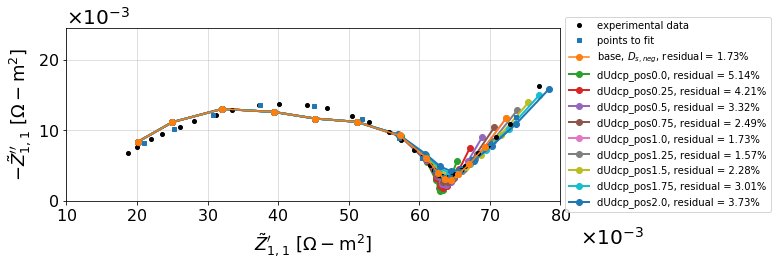

In [48]:
import os
fig = plt.figure(4,figsize=(12,4))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data', markersize=4, color='black', zorder=10)
plt.plot(fit_r, -fit_i, 's', label = 'points to fit', markersize=4, zorder=10)

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))

plt.plot(model_r, -model_i, 'o-', zorder=10, label = r'base, $D_{s,neg}$' + ', residual = {:.2%}'.format(residual/avg_mag))# = -2.67 $\frac{V cm^3}{mol}$', linewidth=3)

directory = '../supplementary-files/local-optimization/outputs/sweep_dUdcp_pos/'
for filename in os.listdir(directory):
    run_name = filename.split('spectra-')[1].split('.txt')[0]

    if 'base' not in run_name:
        data = pd.read_csv(directory + filename, sep = ' ')
        data.columns = [str(float(f)) for f in data.columns]

        mask = [str(f) for f in fit_f]

        Zr = data.loc[0,mask]/base_scale + contact_resistance
        Zi = data.loc[1,mask]/base_scale

        scaled = Zr.values + 1j*Zi.values
        Z11_exp = fit_r + 1j*fit_i
        avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

        residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

        print(run_name + ', residual = {:.2%}'.format(residual/avg_mag))
        plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=2)
    
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

fig.savefig('../supplementary-files/local-optimization/figures/sweep_dudcp_pos.png', dpi=300, bbox_inches='tight')

### Set D$_{s,neg}$ to 0.5x and vary C$_{dl}$s

### Decrease Negative Electrode's Characteristic Frequency (increase $C_{dl,neg}$) & <br>Increase Positive Electrode's Characteristic Frequency (decrease $C_{dl,pos}$)

In [49]:
def calc_kinetics_time_constants(d, electrode):
    i0 = d['i0_' + electrode + '[A/m^2]']
    Cdl = d['Cdl_' + electrode + '[uF/cm^2]']*(100**2)*10**-6
    
    F = 96487
    R = 8.314
    T = 298.15
    
    return Cdl*R*T/(i0*F)

def calc_Rct(d, electrode):
    i0 = d['i0_' + electrode + '[A/m^2]']
#     Cdl = d['Cdl_' + electrode + '[uF/cm^2]']*(100**2)*10**-6
    
    F = 96487
    R = 8.314
    T = 298.15
    
    return R*T/(i0*F)

print('Kinetics Time Constants\n  Negative: {}\n  Positive: {}'.format(calc_kinetics_time_constants(base_parameters, 'neg'),
                                                                   calc_kinetics_time_constants(base_parameters, 'pos')))
print('Kinetics Frequencies\n  Negative: {:.2f}\n  Positive: {:.2f}'.format(1/calc_kinetics_time_constants(base_parameters, 'neg'),
                                                                   1/calc_kinetics_time_constants(base_parameters, 'pos')))

print('\n\nCharge Transfer Resistance\n  Negative: {}\n  Positive: {}'.format(calc_Rct(base_parameters, 'neg'),calc_Rct(base_parameters, 'pos')))

Kinetics Time Constants
  Negative: 0.0010564763947811804
  Positive: 0.014280101952626089
Kinetics Frequencies
  Negative: 946.54
  Positive: 70.03


Charge Transfer Resistance
  Negative: 0.0013232041050850111
  Positive: 0.01650627263895734


In [50]:
print('Cdl_neg', base_parameters['Cdl_neg[uF/cm^2]'], 'uF/cm^2')
print('Cdl_pos', base_parameters['Cdl_pos[uF/cm^2]'], 'uF/cm^2')

Cdl_neg 79.8422851563 uF/cm^2
Cdl_pos 86.5131835938 uF/cm^2


In [51]:
Cdl_pos = 'Cdl_pos[uF/cm^2]'
Cdl_pos_mult = [1.0]*6 + [1.1]*6 + [1.2]*6 + [1.3]*6 + [1.4]*6 + [1.5]*6

Cdl_neg = 'Cdl_neg[uF/cm^2]'
Cdl_neg_mult = [1.0,1.1,1.2,1.3,1.4,1.5]*6


run_list = pd.DataFrame(columns = parameters.columns)
for i, m in enumerate(zip(Cdl_pos_mult, Cdl_neg_mult)):

    new_params = base_parameters.copy()
    new_params['run'] = 'Cdl_neg' + str(m[1]) + '-Cdl_pos' + str(m[0])
    new_params[Cdl_pos] = base_parameters[Cdl_pos]*m[0]
    new_params[Cdl_neg] = base_parameters[Cdl_neg]*m[1]

    new_params['Ds_neg[m^2/s]'] = new_params['Ds_neg[m^2/s]']*0.5
    
    run_list = run_list.append(new_params, ignore_index=True)
        
run_list.sort_index(ascending=False).to_csv('../supplementary-files/local-optimization/inputs/sweep-cdls-together.csv', index=False, index_label=False)

Cdl_neg1.0-Cdl_pos1.0, residual = 1.38%
Cdl_neg1.0-Cdl_pos1.1, residual = 1.47%
Cdl_neg1.0-Cdl_pos1.2, residual = 1.66%
Cdl_neg1.0-Cdl_pos1.3, residual = 1.90%
Cdl_neg1.0-Cdl_pos1.4, residual = 2.15%
Cdl_neg1.0-Cdl_pos1.5, residual = 2.40%
Cdl_neg1.1-Cdl_pos1.0, residual = 1.28%
Cdl_neg1.1-Cdl_pos1.1, residual = 1.40%
Cdl_neg1.1-Cdl_pos1.2, residual = 1.61%
Cdl_neg1.1-Cdl_pos1.3, residual = 1.87%
Cdl_neg1.1-Cdl_pos1.4, residual = 2.14%
Cdl_neg1.1-Cdl_pos1.5, residual = 2.42%
Cdl_neg1.2-Cdl_pos1.0, residual = 1.25%
Cdl_neg1.2-Cdl_pos1.1, residual = 1.40%
Cdl_neg1.2-Cdl_pos1.2, residual = 1.66%
Cdl_neg1.2-Cdl_pos1.3, residual = 1.96%
Cdl_neg1.2-Cdl_pos1.4, residual = 2.27%
Cdl_neg1.2-Cdl_pos1.5, residual = 2.57%
Cdl_neg1.3-Cdl_pos1.0, residual = 1.29%
Cdl_neg1.3-Cdl_pos1.1, residual = 1.47%
Cdl_neg1.3-Cdl_pos1.2, residual = 1.78%
Cdl_neg1.3-Cdl_pos1.3, residual = 2.11%
Cdl_neg1.3-Cdl_pos1.4, residual = 2.44%
Cdl_neg1.3-Cdl_pos1.5, residual = 2.75%
Cdl_neg1.4-Cdl_pos1.0, residual = 1.41%


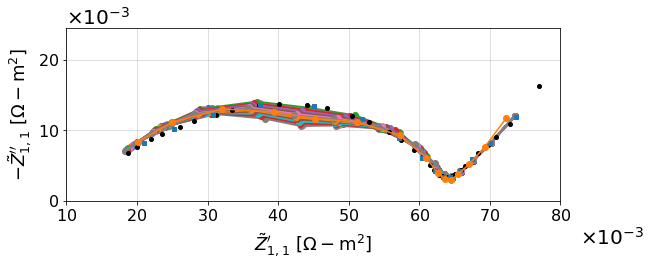

In [52]:
import os
fig = plt.figure(4,figsize=(12,4))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data', markersize=4, color='black', zorder=10)
plt.plot(fit_r, -fit_i, 's', label = 'points to fit', markersize=4, zorder=10)

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))

plt.plot(model_r, -model_i, 'o-', zorder=10, label = r'base, $D_{s,neg}$' + ', residual = {:.2%}'.format(residual/avg_mag))# = -2.67 $\frac{V cm^3}{mol}$', linewidth=3)

directory = '../supplementary-files/local-optimization/outputs/sweep-cdls-together/'
for filename in os.listdir(directory):
    run_name = filename.split('spectra-')[1].split('.txt')[0]

    if 'base' not in run_name:
        data = pd.read_csv(directory + filename, sep = ' ')
        data.columns = [str(float(f)) for f in data.columns]

        mask = [str(f) for f in fit_f]

        Zr = data.loc[0,mask]/base_scale + contact_resistance
        Zi = data.loc[1,mask]/base_scale

        scaled = Zr.values + 1j*Zi.values
        Z11_exp = fit_r + 1j*fit_i
        avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

        residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

        print(run_name + ', residual = {:.2%}'.format(residual/avg_mag))
        plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=2)
    
plt.xlim(0.01,.08)
plt.ylim(0,.0245)

ax.set_xlabel(r'$\tilde{Z}_{1,1}^{\prime}$ [$\Omega-$m$^2$]', fontsize=18, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}_{1,1}^{\prime\prime}$ [$\Omega-$m$^2$]', fontsize=18)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.locator_params(axis='x', nbins=7,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(20)
t = ax.xaxis.get_offset_text()
t.set_size(20)
t.set_position((1.17,0))

# plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

fig.savefig('../supplementary-files/local-optimization/figures/sweep_cdl.png', dpi=300, bbox_inches='tight')

residual = 1.25%


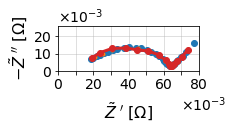

In [53]:
import os
fig = plt.figure(7,figsize=(3.25,2.75))
ax = plt.axes([0,0.2,.6,.6])
plt.plot(calce_r, -calce_i, 'o', label = 'experimental data')
plt.plot(fit_r, -fit_i, '.', label = 'points to fit')

avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()
residual = 1./len(model_r)*sum(np.sqrt((fit_r - model_r)**2 + (fit_i - model_i)**2))
    
directory = '../supplementary-files/local-optimization/outputs/sweep-cdls-together/'
filename = 'spectra-Cdl_neg1.2-Cdl_pos1.0.txt'
run_name = filename.split('spectra-')[1].split('.txt')[0]

data = pd.read_csv(directory + filename, sep = ' ')
data.columns = [str(float(f)) for f in data.columns]

mask = [str(f) for f in fit_f]

Zr = data.loc[0,mask]/base_scale + contact_resistance
Zi = data.loc[1,mask]/base_scale

scaled = Zr.values + 1j*Zi.values
Z11_exp = fit_r + 1j*fit_i
avg_mag = np.sqrt(fit_r**2 + fit_i**2).mean()

residual = 1./len(scaled)*sum(np.sqrt((np.real(Z11_exp) - np.real(scaled))**2 + (np.imag(Z11_exp) + np.imag(scaled))**2))

ax._get_lines.get_next_color()

print('residual = {:.2%}'.format(residual/avg_mag))

plt.plot(Zr, Zi, 'o-', label = run_name + ', residual = {:.2%}'.format(residual/avg_mag), linewidth=3)

plt.xlim(0.00,.08)
plt.ylim(0,.026)

ax.set_xlabel(r'$\tilde{Z}^{\ \prime}$ [$\Omega$]', fontsize=16, labelpad=8)
ax.set_ylabel(r'$-\tilde{Z}^{\ \prime\prime}$ [$\Omega$]', fontsize=16)

ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.locator_params(axis='x', nbins=8,tight=True)
ax.locator_params(axis='y', nbins=3,tight=True)
ax.grid(b=True, which='major', axis='both', alpha=.5)
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
y_offset = ax.yaxis.get_offset_text()
y_offset.set_size(14)
t = ax.xaxis.get_offset_text()
t.set_size(14)
t.set_position((1.2,0))

plt.show()

fig.savefig('../figures/Figure 7/Figure7.png', dpi=300, bbox_inches='tight')

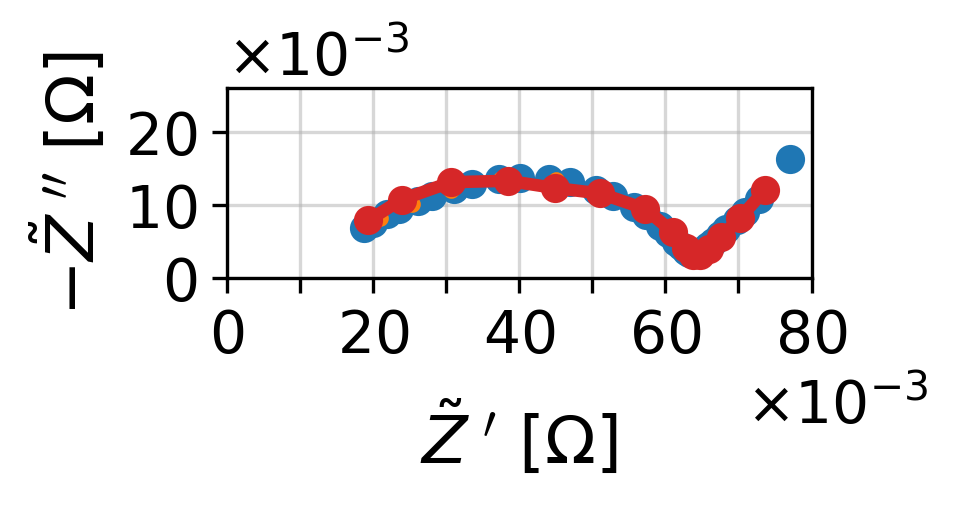

In [54]:
from IPython.display import Image

Image("../figures/Figure 7/Figure7.png", width="50%", embed=True)

## Generate Parameters for Dataset

In [55]:
import numpy as np
import pandas as pd

from SALib.sample import saltelli
from SALib.util import read_param_file

In [56]:
data = pd.read_table(r'../supplementary-files/dataset/parameter-ranges.txt', delimiter=' ')

In [57]:
data.head()

name   lower_bound  upper_bound units
0   l_neg  1.500000e-05     0.001200   [m]
1   l_sep  8.000000e-06     0.000040   [m]
2   l_pos  1.500000e-05     0.001200   [m]
3  Rp_neg  5.000000e-07     0.000020   [m]
4  Rp_pos  1.000000e-06     0.000015   [m]

In [58]:
data['new_lower_bound'] = np.log10(data['lower_bound'])
data['new_upper_bound'] = np.log10(data['upper_bound'])
data = data.replace(-np.inf, -2)

data['final_lower_bound'] = data['lower_bound']
data['final_upper_bound'] = data['upper_bound']
data['log_sample?'] = 'n'
data.loc[np.abs(data['new_upper_bound'] - data['new_lower_bound']) > 2, 'log_sample?'] = 'y'

C:\Users\Matt\Miniconda3\envs\ImpedanceAnalyzerManuscript\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\Matt\Miniconda3\envs\ImpedanceAnalyzerManuscript\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [59]:
data.loc[data['log_sample?']=='y', 'final_lower_bound'] = data.loc[data['log_sample?']=='y', 'new_lower_bound']
data.loc[data['log_sample?']=='y', 'final_upper_bound'] = data.loc[data['log_sample?']=='y', 'new_upper_bound']
data.head()

name   lower_bound  upper_bound units  new_lower_bound  new_upper_bound  \
0   l_neg  1.500000e-05     0.001200   [m]        -4.823909        -2.920819   
1   l_sep  8.000000e-06     0.000040   [m]        -5.096910        -4.397940   
2   l_pos  1.500000e-05     0.001200   [m]        -4.823909        -2.920819   
3  Rp_neg  5.000000e-07     0.000020   [m]        -6.301030        -4.698970   
4  Rp_pos  1.000000e-06     0.000015   [m]        -6.000000        -4.823909   

   final_lower_bound  final_upper_bound log_sample?  
0       1.500000e-05           0.001200           n  
1       8.000000e-06           0.000040           n  
2       1.500000e-05           0.001200           n  
3       5.000000e-07           0.000020           n  
4       1.000000e-06           0.000015           n

In [60]:
final_params = pd.DataFrame()
final_params['# name'] = data['name']
final_params['lower_bound'] = data['final_lower_bound']
final_params['upper_bound'] = data['final_upper_bound']
final_params['units'] = data['units']
final_params['log_sample?'] = data['log_sample?']

final_params.head()

# name   lower_bound  upper_bound units log_sample?
0   l_neg  1.500000e-05     0.001200   [m]           n
1   l_sep  8.000000e-06     0.000040   [m]           n
2   l_pos  1.500000e-05     0.001200   [m]           n
3  Rp_neg  5.000000e-07     0.000020   [m]           n
4  Rp_pos  1.000000e-06     0.000015   [m]           n

In [61]:
final_params.to_csv('../supplementary-files/dataset/final-param-ranges.txt', sep=' ', header=None, index=None)
final_params.iloc[:,0:4].to_csv('../supplementary-files/dataset/param-ranges-for-saltelli.txt', sep=' ', header=None, index=None)

In [62]:
problem = read_param_file('../supplementary-files/dataset/param-ranges-for-saltelli.txt')

param_values = saltelli.sample(problem, 2000, calc_second_order=True)

model_runs = pd.DataFrame(param_values, columns=[(final_params['# name'] + final_params['units']).tolist()])

In [63]:
for column in model_runs.columns:
    name = column.split('[')[0]
    if (final_params.loc[final_params['# name'] == name, 'log_sample?'] == 'y').tolist()[0]:
        model_runs[column] = 10**model_runs[column]

In [64]:
model_runs['dUdcp_neg[V*cm^3/mol]'] = -1*model_runs['dUdcp_neg_mag[V*cm^3/mol]']
model_runs['dUdcp_pos[V*cm^3/mol]'] = -1*model_runs['dUdcp_pos_mag[V*cm^3/mol]']

model_runs['d2Udcp2_neg[V*cm^6/mol^2]'] = np.sign(model_runs['d2Udcp2_neg_sgn[1]'])*model_runs['d2Udcp2_neg_mag[V*cm^6/mol^2]']
model_runs['d2Udcp2_pos[V*cm^6/mol^2]'] = np.sign(model_runs['d2Udcp2_pos_sgn[1]'])*model_runs['d2Udcp2_pos_mag[V*cm^6/mol^2]']

model_runs['d3Udcp3_neg[V*cm^9/mol^3]'] = np.sign(model_runs['d3Udcp3_neg_sgn[1]'])*model_runs['d3Udcp3_neg_mag[V*cm^9/mol^3]']
model_runs['d3Udcp3_pos[V*cm^9/mol^3]'] = np.sign(model_runs['d3Udcp3_pos_sgn[1]'])*model_runs['d3Udcp3_pos_mag[V*cm^9/mol^3]']

In [65]:
model_runs = model_runs.drop(['dUdcp_neg_mag[V*cm^3/mol]','dUdcp_pos_mag[V*cm^3/mol]',
                              'd2Udcp2_neg_mag[V*cm^6/mol^2]','d2Udcp2_pos_mag[V*cm^6/mol^2]',
                              'd3Udcp3_neg_mag[V*cm^9/mol^3]','d3Udcp3_pos_mag[V*cm^9/mol^3]',
                              'd2Udcp2_neg_sgn[1]', 'd2Udcp2_pos_sgn[1]',
                              'd3Udcp3_neg_sgn[1]', 'd3Udcp3_pos_sgn[1]'], 1)

In [66]:
model_runs.index = range(1,len(model_runs)+1)

In [67]:
model_runs.to_csv('../supplementary-files/dataset/model_runs.txt', index_label='run')

## Join all simulation files into final dataset

#### Use shell magic to execute compile_dataset.py

`compile_dataset.py` is a script which compiles each of the 38,800 individual simulation result .txt files into a single .csv file for easier storage and use.

The script has flags for `--directory` (location of input files), `--output` (location to save final file), and `--verbose` (to output a progress bar and results to the shell if desired).

In [68]:
! cd utilities && python compile_dataset.py --directory "../../supplementary-files/dataset/raw_data/" --output "../../supplementary-files/dataset/"


Completed in 0 hours, 4 minutes, and 20 seconds


#### An example of reading the .csv file into a complex valued dataframe

In [69]:
import pandas as pd

data = pd.read_csv('../supplementary-files/dataset/38800-Z.csv', index_col=0)
real = [a for a in data.columns if 'real' in a]
real_df = data[real]
real_df.columns = [float(a.split('_real')[0]) for a in real_df.columns]

imag = [a for a in data.columns if 'imag' in a]
imag_df = data[imag]
imag_df.columns = [float(a.split('_imag')[0]) for a in imag_df.columns]

final_df = real_df + imag_df*1j
final_df.head()

100000.000000                 46415.890000   \
1  (0.0003274816-8.213739e-05j)  (0.0003686147-0.0001197695j)   
2  (0.0007190004-8.561472e-05j)  (0.0007623018-0.0001266792j)   
3   (0.0007325564-0.000104876j)  (0.0007825998-0.0001532489j)   
4   (0.000332678-8.222355e-05j)  (0.0003798862-0.0001130942j)   
5   (0.0003274782-8.21336e-05j)  (0.0003686096-0.0001197639j)   

                  21544.350000                  10000.000000   \
1   (0.0004318469-0.000170195j)  (0.0005284095-0.0002292191j)   
2   (0.000829322-0.0001812569j)  (0.0009319153-0.0002453701j)   
3     (0.00085712-0.000222531j)  (0.0009682548-0.0003185482j)   
4   (0.0004516719-0.000139521j)  (0.0005371224-0.0001394144j)   
5  (0.0004318399-0.0001701864j)  (0.0005284002-0.0002292052j)   

                  4641.589000                   2154.435000    \
1  (0.0006595862-0.0002796552j)  (0.0007997598-0.0003216248j)   
2     (0.0010718-0.0003015686j)    (0.00122304-0.0003503953j)   
3   (0.001129209-0.0004452184j)   (0.001351834-0.0006145254j)   
4  (0.0006005548-0.0001200009j)  (0.0006429067-0.0001170505j)   
5  (0.0006595748-0.0002796303j)  (0.0007997468-0.0003215755j)   

                  1000.000000                   464.158900     \
1  (0.0009537308-0.0003924319j)     (0.0011705-0.0004952729j)   
2   (0.001391691-0.0004308807j)   (0.001631071-0.0005459812j)   
3    (0.00167374-0.0008479528j)    (0.002173364-0.001127293j)   
4  (0.0006874221-0.0001408568j)  (0.0007492698-0.0001909582j)   
5    (0.000953715-0.000392329j)   (0.001170475-0.0004950563j)   

                  215.443500                    100.000000     \
1   (0.001490107-0.0005650709j)   (0.001841224-0.0004917689j)   
2   (0.001985491-0.0006243669j)   (0.002377031-0.0005347052j)   
3    (0.002924676-0.001309656j)     (0.003756353-0.00112414j)   
4  (0.0008418299-0.0002692709j)  (0.0009852664-0.0003773684j)   
5   (0.001490057-0.0005646207j)    (0.001841104-0.000490838j)   

              ...                            1.000000       \
1             ...                (0.002240387-0.00010822j)   
2             ...              (0.002785518-0.0001114146j)   
3             ...              (0.004462213-5.392739e-05j)   
4             ...              (0.002235948-0.0001651823j)   
5             ...              (0.002219888-8.072707e-05j)   

                 0.464159                     0.215444       \
1  (0.002288401-0.0001407544j)  (0.002351237-0.0001936064j)   
2  (0.002835526-0.0001435712j)  (0.002900111-0.0001957971j)   
3  (0.004475029-6.745147e-05j)  (0.004492377-0.0001053969j)   
4  (0.002287061-0.0001672862j)  (0.002350561-0.0002059183j)   
5  (0.002253733-0.0001014348j)   (0.00229703-0.0001391596j)   

                 0.100000                     0.046416       \
1  (0.002436629-0.0002765274j)  (0.002554397-0.0004079758j)   
2   (0.00298853-0.0002769536j)   (0.00311016-0.0004016021j)   
3   (0.004518701-0.000183891j)  (0.004562764-0.0003388765j)   
4  (0.002436089-0.0002822258j)  (0.002553879-0.0004105963j)   
5  (0.002356087-0.0002009933j)   (0.00243674-0.0003023886j)   

                 0.021544                     0.010000       \
1  (0.002720142-0.0006225691j)  (0.002962287-0.0009837562j)   
2  (0.003278471-0.0006016039j)  (0.003526269-0.0009358402j)   
3   (0.004648215-0.000642178j)   (0.004845377-0.001222946j)   
4  (0.002719623-0.0006237434j)  (0.002961764-0.0009842179j)   
5  (0.002549245-0.0004765755j)  (0.002719626-0.0007863602j)   

                0.004642                    0.002154       \
1  (0.003334619-0.001595358j)  (0.003893797-0.002644932j)   
2  (0.003931735-0.001490438j)  (0.004641765-0.002343714j)   
3   (0.00534482-0.002249922j)  (0.006470333-0.003807825j)   
4  (0.003334091-0.001595393j)  (0.003893232-0.002644556j)   
5  (0.003004501-0.001323829j)  (0.003439421-0.002239832j)   

                0.001000       
1  (0.004823016-0.004589574j)  
2  (0.005839407-0.003523186j)  
3  (0.008584029-0.005821492j)  
4  (0.004822252-0.004588589j)  
5  (0.004124644-0.00399474

#### The parameters which generate each of the simulation runs can also be inserted to achieve the full inputs and outputs in a single dataset

In [70]:
parameters = pd.read_csv('../supplementary-files/dataset/model_runs.txt', index_col=0)

In [71]:
pd.concat([parameters.iloc[:len(final_df),:], final_df], axis=1).to_csv('../supplementary-files/dataset/full_dataset.csv')